# SC Cosmetics 

## Import Libaries

In [3]:
!pip install pyathena
!pip install imbalanced-learn
!pip install -q smclarify==0.1

import boto3
import sagemaker

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyathena import connect
from imblearn.over_sampling import SMOTE

from smclarify.bias import report
from typing import Dict
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'

  Using cached pyathena-3.5.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
Using cached pyathena-3.5.1-py3-none-any.whl (69 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached imbalanced_learn-0.12.0-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.12.0-py3-none-any.whl (257 kB)
DEP

## Copy Data from S3
https://sc-cosmetics-data.s3.amazonaws.com/chemicals-in-cosmetics/cosmetic_chemicals.csv

https://sc-cosmetics-data.s3.amazonaws.com/cosmetic-ingedients-ranking-pricing/cosmetics.csv

https://sc-cosmetics-data.s3.amazonaws.com/customer-propensity-to-purchase/customer.csv

In [4]:
# define the S3 bucket, role, and region
sess = sagemaker.Session()
bucket = "sc-cosmetics-data"  
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# define S3 paths for the source (public) and destination (private) locations
s3_public_path_chemicals = "s3://sc-cosmetics-data/chemicals-in-cosmetics"
s3_public_path_cosmetics = "s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing"
s3_public_path_customer = "s3://sc-cosmetics-data/customer-propensity-to-purchase"
s3_private_path = f"s3://{bucket}/"  
s3_private_path_chemicals = f"s3://{bucket}/chemicals-in-cosmetics"
s3_private_path_cosmetics = f"s3://{bucket}/cosmetic-ingredients-ranking-pricing"
s3_private_path_customer = f"s3://{bucket}/customer-propensity-to-purchase"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
# copy data from the public S3 buckets to our private S3 buckets
!aws s3 cp --recursive $s3_public_path_chemicals/ $s3_private_path_chemicals/
!aws s3 cp --recursive $s3_public_path_cosmetics/ $s3_private_path_cosmetics/
!aws s3 cp --recursive $s3_public_path_customer/ $s3_private_path_customer/

copy: s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv to s3://sc-cosmetics-data/chemicals-in-cosmetics/cosmetic_chemicals.csv
copy: s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv to s3://sc-cosmetics-data/cosmetic-ingredients-ranking-pricing/cosmetics.csv
copy: s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv to s3://sc-cosmetics-data/customer-propensity-to-purchase/customer.csv


In [6]:
# list files in private S3 bucket
print("Files in private S3 bucket - Chemicals:")
!aws s3 ls $s3_private_path_chemicals/

print("\nFiles in private S3 bucket - Cosmetics:")
!aws s3 ls $s3_private_path_cosmetics/

print("\nFiles in private S3 bucket - Customer:")
!aws s3 ls $s3_private_path_customer/

Files in private S3 bucket - Chemicals:
2024-03-23 16:46:43   23962866 cosmetic_chemicals.csv

Files in private S3 bucket - Cosmetics:
2024-03-23 16:46:45    1157561 cosmetics.csv

Files in private S3 bucket - Customer:
2024-03-23 16:46:46   35077633 customer.csv


In [7]:
# read files into pd df
chemicals_df = pd.read_csv(s3_private_path_chemicals + "/cosmetic_chemicals.csv")
cosmetics_df = pd.read_csv(s3_private_path_cosmetics + "/cosmetics.csv")
customer_df = pd.read_csv(s3_private_path_customer + "/customer.csv")

## Data Exploration

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
chemicals_df.head()

,ProductName,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,SubCategory,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalCount,Discontinued,ChemicalRemoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [10]:
chemicals_df['PrimaryCategory'].value_counts() 

Makeup Products (non-permanent)      75827
Nail Products                        15347
Skin Care Products                    7683
Sun-Related Products                  4939
Bath Products                         3466
Hair Coloring Products                2061
Hair Care Products (non-coloring)     1620
Tattoos and Permanent Makeup          1477
Personal Care Products                 765
Fragrances                             654
Oral Hygiene Products                  525
Shaving Products                       222
Baby Products                           49
Name: PrimaryCategory, dtype: int64

In [11]:
cosmetics_df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,brand_id,product_id
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [12]:
cosmetics_df['Label'].value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [13]:
customer_df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,766.0


Since the cosmetics dataframe exclusively comprises skincare items, our analysis will focus solely on skincare products and those associated with sun protection from the chemicals present in the cosmetic dataframe.

## Table Manipulation

### chemicals table

In [14]:
# convert columns to binary values
# chemicals_df['Discontinued'] = chemicals_df['DiscontinuedDate'].notna().astype(int)
# chemicals_df['ChemicalRemoved'] = chemicals_df['ChemicalDateRemoved'].notna().astype(int)

In [15]:
# drop unneeded columns
# drop_columns = ['CDPHId', 'CSFId', 'CSF', 'CasId', 'CasNumber', 'DiscontinuedDate', 'ChemicalDateRemoved']
# chemicals_df = chemicals_df.drop(columns=drop_columns)

In [16]:
# removed commas from SubCategory
# chemicals_df['SubCategory'] = chemicals_df['SubCategory'].str.replace(',', '')

In [17]:
# convert date columns to proper format
# chemicals_df['InitialDateReported'] = pd.to_datetime(chemicals_df['InitialDateReported'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['MostRecentDateReported'] = pd.to_datetime(chemicals_df['MostRecentDateReported'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['ChemicalCreatedAt'] = pd.to_datetime(chemicals_df['ChemicalCreatedAt'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# chemicals_df['ChemicalUpdatedAt'] = pd.to_datetime(chemicals_df['ChemicalUpdatedAt'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

In [18]:
# add brand_id to cosmetics and chemical tables
# chemicals_df['brand_id'] = chemicals_df.groupby(['BrandName']).ngroup()
# cosmetics_df['brand_id'] = cosmetics_df.groupby(['Brand']).ngroup()

In [19]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# chemicals_df_modified = chemicals_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='chemicals-in-cosmetics/cosmetic_chemicals.csv', Body=chemicals_df_modified)

### cosmetics table

In [20]:
# removed commas from Ingredients
# cosmetics_df['Ingredients'] = cosmetics_df['Ingredients'].str.replace(',', '-')

In [21]:
# cosmetics_df['product_id'] = range(1, len(cosmetics_df) + 1)

In [22]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# cosmetics_df_modified = cosmetics_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='cosmetic-ingredients-ranking-pricing/cosmetics.csv', Body=cosmetics_df_modified)

### customer table

In [23]:
# drop unneeded columns
# drop_columns = ['promo_banner_click', 'image_picker', 'saw_sizecharts', 'saw_account_upgrade']
# customer_df = customer_df.drop(columns=drop_columns)

In [24]:
# create new column for product_id purchased
# customer_df['product_id'] = np.nan

# randomly generate a product_id for each row where ordered = 1
# for index, row in customer_df.iterrows():
#    if row['ordered'] == 1:
#        product_id_generation = cosmetics_df.sample()['product_id'].values[0]
#        customer_df.at[index, 'product_id'] = product_id_generation
        
# customer_df['product_id'] = customer_df['product_id'].astype('Int64')

In [25]:
# s3 = boto3.client('s3')

# convert dataframe back to CSV
# customer_df_modified = customer_df.to_csv(index=False)

# resave to S3
# s3.put_object(Bucket=bucket, Key='customer-propensity-to-purchase/customer.csv', Body=customer_df_modified)

## Create Athena Database

In [26]:
# athena database name
db_name = 'sc_cosmetics'

In [27]:
# S3 staging directory
s3_staging = "s3://{0}/athena/staging".format(bucket)

In [28]:
# create connection for athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging)

In [29]:
create_query = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(create_query, conn)

""


In [30]:
# create chemicals in cosmetics table
chem_table_name ='cosmetic_chemicals'

# chemical data S3 directory
chem_s3_dir = f's3://{bucket}/chemicals-in-cosmetics'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{chem_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{chem_table_name}(
                ProductName string,
                CompanyID int,
                CompanyName string,
                BrandName string,
                PrimaryCategoryID int,
                PrimaryCategory string,
                SubCategoryID int,
                SubCategory string,
                ChemicalID int,
                ChemicalName string,
                InitialDateReported date,
                MostRecentDateReported date,
                ChemicalCreatedAt date,
                ChemicalUpdatedAt date,
                ChemicalCount int,
                Discontinued int,
                ChemicalRemoved int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{chem_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [31]:
# view top 5 rows of chemical_cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{chem_table_name} LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [32]:
# create subquery with the skin care products and sun-related products 

skinproducts_sub = ["Sun-Related Products", "Skin Care Products "]
in_clause = "', '".join(skinproducts_sub)

sub_query = f"""
            (
            SELECT *
            FROM sc_cosmetics.cosmetic_chemicals
            WHERE PrimaryCategory IN ('{in_clause}')
            )
"""

# create a new table using the subquery
cosmetic_chemicals_sub = f"""
                         CREATE TABLE IF NOT EXISTS {db_name}.cosmetic_chemicals_sub AS {sub_query}
                         """

# Execute the create table query
with conn.cursor() as cursor:
    cursor.execute(cosmetic_chemicals_sub)

In [33]:
# create cosmetics table
cos_table_name ='cosmetics'

# cosmetics data S3 directory
cos_s3_dir = f's3://{bucket}/cosmetic-ingredients-ranking-pricing'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cos_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cos_table_name}(
                Label string,
                Brand string,
                Name string,
                Price float,
                Rank float,
                Ingredients string,
                Combination int,
                Dry int,
                Normal int,
                Oily int,
                Sensitive int,
                product_id int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cos_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [34]:
# view top 5 rows of cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{cos_table_name} LIMIT 5', conn)

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id
0,Moisturizer,LA MER,Crème de la Mer,175.0,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179.0,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175.0,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [35]:
# create customer table
cust_table_name ='customer'

# customer data S3 directory
cust_s3_dir = f's3://{bucket}/customer-propensity-to-purchase'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cust_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cust_table_name}(
                UserID string,
                basket_icon_click int,
                basket_add_list int,
                basket_add_detail int,
                sort_by int,
                account_page_click int,
                detail_wishlist_add int,
                list_size_dropdown int,
                closed_minibasket_click int,
                checked_delivery_detail int,
                checked_returns_detail int,
                sign_in int,
                saw_checkout int,
                saw_delivery int,
                saw_homepage int,
                device_mobile int,
                device_computer int,
                device_tablet int,
                returning_user int,
                loc_uk int,
                ordered int,
                product_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cust_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [36]:
# view top 5 rows of customer table
pd.read_sql(f'SELECT * FROM {db_name}.{cust_table_name} LIMIT 5', conn)

,userid,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,766.0


In [37]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,sc_cosmetics


In [38]:
# define query to show tables in db
show_tables_query = f"SHOW TABLES IN {db_name}"

# execute query+ display tables in db
tables_df = pd.read_sql(show_tables_query, conn)
tables_df

,tab_name
0,cosmetic_chemicals
1,cosmetic_chemicals_sub
2,cosmetics
3,customer
4,sc_cosmetics_app
5,skin_products


In [39]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [40]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [41]:
# define SQL query
original_query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        LEFT JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        LEFT JOIN sc_cosmetics.skin_products ccc ON c.brand_id = ccc.brand_id;
        """

In [42]:
# define SQL query
new_query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.cosmetics c
        LEFT JOIN sc_cosmetics.customer cu ON c.product_id = cu.product_id
        LEFT JOIN sc_cosmetics.skin_products ccc ON ccc.brand_id = c.brand_id;
        """

In [43]:
# define SQL query
updated_query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        INNER JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        INNER JOIN sc_cosmetics.skin_products ccc ON c.brand_id = ccc.brand_id;
        """

In [44]:
sc_old_df = pd.read_sql(original_query, conn)

In [45]:
sc_df = pd.read_sql(new_query, conn)

In [46]:
sc_df2 = pd.read_sql(updated_query, conn)

In [47]:
sc_df.sample(n=10, random_state=42)

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
56720,a11e-1c0952dc-a11e-4d5c-a153-549333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,Face Mask,SEPHORA COLLECTION,Face Mask - Grape - Anti-pollution,6.0,5.0,Water- Butylene Glycol- Glycerin- Betaine- Alo...,1.0,1.0,1,1,1,93,954,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
35389,2a30-ca112c00-2a30-46b6-b96b-161505,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,Sun protect,COOLA,Sport Continuous Spray SPF 30 - Piña Colada,36.0,4.5,Alcohol (Organic)- Algae Extract (Organic)- Al...,1.0,1.0,1,1,1,20,1451,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,1.0,0.0
43973,4120-c51ea7d6-4120-48dd-a427-647126,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,Cleanser,GLAMGLOW,YOUTHMUD™ Tinglexfoliate Treatment,59.0,4.1,Water- Montmorillonite- Kaolin- Magnesium Alum...,1.0,1.0,1,1,0,41,349,Skin Care Products,Other Skin Care Product,Triethanolamine,2.0,0.0,0.0
37160,cc09-315b5352-cc09-4676-a890-959132,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,Treatment,PETER THOMAS ROTH,FIRMx Growth Factor Extreme Neuropeptide Serum,150.0,4.2,Water- Glycerin- Caprylic/Capric Triglyceride-...,0.0,0.0,0,0,0,87,816,Skin Care Products,Anti-Wrinkle/Anti-Aging Products (making a cos...,Oil Orange SS,1.0,0.0,0.0
45419,6777-d3c524d9-6777-4979-ad0b-185904,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,Cleanser,CAUDALIE,Vinopure Natural Salicylic Acid Pore Minimizin...,28.0,3.8,*Plant origin.,1.0,0.0,1,1,1,15,352,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,2.0,1.0,0.0
41729,d714-1e7c7av4-d714-b104-b836-774044,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4.3,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1.0,1.0,1,0,1,108,886,Sun-Related Products,Indoor Tanning Products,Titanium dioxide,1.0,0.0,0.0
57358,c899-d64354b6-c899-4784-a3a1-417803,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,Face Mask,SEPHORA COLLECTION,Hydrating Lip Mask,3.0,3.0,Water- Butylene Glycol- Glycerin- Propanediol-...,0.0,0.0,0,0,0,93,977,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
37358,a2c6-61b747a2-a2c6-4861-b69b-109646,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,Treatment,SEPHORA COLLECTION,3-in-1 Extractor,23.0,3.9,Visit the SEPHORA COLLECTION boutique,0.0,0.0,0,0,0,93,822,None,None,None,NaN,NaN,NaN
55627,9674-0b7c6b16-9674-b151-977d-677647,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,Treatment,HERBIVORE,Blue Tansy AHA + BHA Resurfacing Clarity Mask,48.0,4.5,Aloe Barbadensis (Organic Aloe) Leaf Juice- Hy...,1.0,0.0,1,1,0,45,603,None,None,None,NaN,NaN,NaN
35225,b7b7-b37d6b76-b7b7-47a1-ad00-219111,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,Sun protect,PHILOSOPHY,Ultimate Miracle Worker Multi-Rejuvenating Lig...,75.0,3.7,Water- Butylene Glycol- C12-15 Alkyl Benzoate-...,1.0,1.0,1,1,1,88,1448,None,None,None,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

In [48]:
# inspect df 
print('Number of Rows:', sc_old_df.shape[0])
print('Number of Columns:', sc_old_df.shape[1], '\n')
 
sc_old_df.info()

Number of Rows: 522059
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522059 entries, 0 to 522058
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   UserID               522059 non-null  object 
 1   basket_icon_click    522059 non-null  int64  
 2   basket_add_list      522059 non-null  int64  
 3   account_page_click   522059 non-null  int64  
 4   detail_wishlist_add  522059 non-null  int64  
 5   saw_checkout         522059 non-null  int64  
 6   device_mobile        522059 non-null  int64  
 7   device_computer      522059 non-null  int64  
 8   device_tablet        522059 non-null  int64  
 9   returning_user       522059 non-null  int64  
 10  ordered              522059 non-null  int64  
 11  label                68136 non-null   object 
 12  brand                68136 non-null   object 
 13  name                 68136 non-null   object 
 14  price                

In [49]:
# inspect df 
print('Number of Rows:', sc_df.shape[0])
print('Number of Columns:', sc_df.shape[1], '\n')

sc_df.info()

Number of Rows: 68179
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68179 entries, 0 to 68178
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               68136 non-null  object 
 1   basket_icon_click    68136 non-null  float64
 2   basket_add_list      68136 non-null  float64
 3   account_page_click   68136 non-null  float64
 4   detail_wishlist_add  68136 non-null  float64
 5   saw_checkout         68136 non-null  float64
 6   device_mobile        68136 non-null  float64
 7   device_computer      68136 non-null  float64
 8   device_tablet        68136 non-null  float64
 9   returning_user       68136 non-null  float64
 10  ordered              68136 non-null  float64
 11  label                68179 non-null  object 
 12  brand                68179 non-null  object 
 13  name                 68179 non-null  object 
 14  price                67893 non-null  flo

In [50]:
# inspect df 
print('Number of Rows:', sc_df2.shape[0])
print('Number of Columns:', sc_df2.shape[1], '\n')

sc_df2.info()

Number of Rows: 53325
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53325 entries, 0 to 53324
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               53325 non-null  object 
 1   basket_icon_click    53325 non-null  int64  
 2   basket_add_list      53325 non-null  int64  
 3   account_page_click   53325 non-null  int64  
 4   detail_wishlist_add  53325 non-null  int64  
 5   saw_checkout         53325 non-null  int64  
 6   device_mobile        53325 non-null  int64  
 7   device_computer      53325 non-null  int64  
 8   device_tablet        53325 non-null  int64  
 9   returning_user       53325 non-null  int64  
 10  ordered              53325 non-null  int64  
 11  label                53325 non-null  object 
 12  brand                53325 non-null  object 
 13  name                 53325 non-null  object 
 14  price                53085 non-null  flo

### Identifying and Removing Null Values

In [51]:
# identifying missing values after joining of the three df 
sc_old_df.isnull().sum()

UserID                      0
basket_icon_click           0
basket_add_list             0
account_page_click          0
detail_wishlist_add         0
saw_checkout                0
device_mobile               0
device_computer             0
device_tablet               0
returning_user              0
ordered                     0
label                  453923
brand                  453923
name                   453923
price                  454203
rank                   454163
ingredients            453923
combination            453963
dry                    454163
normal                 453923
oily                   453923
sensitive              453923
product_id             453923
brand_id               453923
PrimaryCategory        468734
SubCategory            468734
ChemicalName           468734
ChemicalCount          469238
Discontinued           468758
ChemicalRemoved        468758
dtype: int64

In [52]:
sc_df.isnull().sum()

UserID                    43
basket_icon_click         43
basket_add_list           43
account_page_click        43
detail_wishlist_add       43
saw_checkout              43
device_mobile             43
device_computer           43
device_tablet             43
returning_user            43
ordered                   43
label                      0
brand                      0
name                       0
price                    286
rank                     240
ingredients                0
combination               46
dry                      240
normal                     0
oily                       0
sensitive                  0
product_id                 0
brand_id                   0
PrimaryCategory        14840
SubCategory            14840
ChemicalName           14840
ChemicalCount          15344
Discontinued           14864
ChemicalRemoved        14864
dtype: int64

In [53]:
sc_df2.isnull().sum()

UserID                   0
basket_icon_click        0
basket_add_list          0
account_page_click       0
detail_wishlist_add      0
saw_checkout             0
device_mobile            0
device_computer          0
device_tablet            0
returning_user           0
ordered                  0
label                    0
brand                    0
name                     0
price                  240
rank                   240
ingredients              0
combination              0
dry                    240
normal                   0
oily                     0
sensitive                0
product_id               0
brand_id                 0
PrimaryCategory          0
SubCategory              0
ChemicalName             0
ChemicalCount          504
Discontinued            24
ChemicalRemoved         24
dtype: int64

In [54]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_old_df.isnull().sum() / len(sc_old_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          89.882178
ChemicalRemoved        89.790234
Discontinued           89.790234
ChemicalName           89.785637
SubCategory            89.785637
PrimaryCategory        89.785637
price                  87.002235
dry                    86.994573
rank                   86.994573
combination            86.956264
normal                 86.948602
label                  86.948602
brand                  86.948602
name                   86.948602
ingredients            86.948602
oily                   86.948602
sensitive              86.948602
product_id             86.948602
brand_id               86.948602
device_mobile           0.000000
basket_add_list         0.000000
account_page_click      0.000000
detail_wishlist_add     0.000000
saw_checkout            0.000000
returning_user          0.000000
ordered                 0.000000
device_computer         0.000000
basket_icon_click       0.000000
device_tablet           0.000000
UserID

In [55]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df.isnull().sum() / len(sc_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          22.505464
ChemicalRemoved        21.801434
Discontinued           21.801434
ChemicalName           21.766233
SubCategory            21.766233
PrimaryCategory        21.766233
price                   0.419484
dry                     0.352015
rank                    0.352015
combination             0.067469
returning_user          0.063069
device_computer         0.063069
basket_add_list         0.063069
account_page_click      0.063069
detail_wishlist_add     0.063069
saw_checkout            0.063069
device_mobile           0.063069
ordered                 0.063069
UserID                  0.063069
basket_icon_click       0.063069
device_tablet           0.063069
ingredients             0.000000
oily                    0.000000
sensitive               0.000000
product_id              0.000000
brand_id                0.000000
name                    0.000000
brand                   0.000000
label                   0.000000
normal

In [56]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df2.isnull().sum() / len(sc_df2)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          0.945148
rank                   0.450070
price                  0.450070
dry                    0.450070
Discontinued           0.045007
ChemicalRemoved        0.045007
device_mobile          0.000000
device_computer        0.000000
basket_add_list        0.000000
account_page_click     0.000000
ChemicalName           0.000000
SubCategory            0.000000
PrimaryCategory        0.000000
brand_id               0.000000
product_id             0.000000
sensitive              0.000000
oily                   0.000000
normal                 0.000000
detail_wishlist_add    0.000000
combination            0.000000
ingredients            0.000000
basket_icon_click      0.000000
saw_checkout           0.000000
name                   0.000000
brand                  0.000000
label                  0.000000
ordered                0.000000
returning_user         0.000000
device_tablet          0.000000
UserID                 0.000000
dty

In [57]:
# impute values with rows missing less than 20% data 
low_missing_cols = ['ChemicalCount', 'price', 'rank', 'dry','ChemicalRemoved', 'Discontinued']

In [58]:
# impute missing values in numerical columns with their mean
sc_df2[low_missing_cols] = sc_df2[low_missing_cols].fillna(sc_df2[low_missing_cols].mean())

In [59]:
sc_df2.isnull().sum() # confrim misisng values are handles 

UserID                 0
basket_icon_click      0
basket_add_list        0
account_page_click     0
detail_wishlist_add    0
saw_checkout           0
device_mobile          0
device_computer        0
device_tablet          0
returning_user         0
ordered                0
label                  0
brand                  0
name                   0
price                  0
rank                   0
ingredients            0
combination            0
dry                    0
normal                 0
oily                   0
sensitive              0
product_id             0
brand_id               0
PrimaryCategory        0
SubCategory            0
ChemicalName           0
ChemicalCount          0
Discontinued           0
ChemicalRemoved        0
dtype: int64

In [60]:
sc_df2.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Masks,Titanium dioxide,1.0,0.0,0.0
1,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
2,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0
3,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Skin Care Products,Facial Cream,Titanium dioxide,1.0,0.0,0.0
4,6a76-av3d7av7-6a76-46b7-8b97-495552,1,0,0,0,1,0,0,1,0,1,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4.1,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1.0,1,1,1,97,1420,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0


In [61]:
sc_df2['ChemicalName'].value_counts()

Titanium dioxide                       43681
Triethanolamine                         1947
Vitamin A palmitate                      834
Butylated hydroxyanisole                 819
Retinyl palmitate                        794
Coffea arabica extract                   708
Retinol                                  635
Trade Secret                             592
Mica                                     283
"Titanium dioxide (airborne              280
Caffeine                                 248
Estragole                                244
Cocamide diethanolamine                  243
Coffee                                   197
Oil Orange SS                            186
Methyleugenol                            185
Ginkgo biloba extract                    175
Cosmetic talc                            132
beta-Myrcene                             127
Avobenzone                               108
"Silica                                  100
"Mineral oils                             80
Toluene   

In [62]:
sc_old_df.shape #30 columns and 52059 rows of data 

(522059, 30)

In [63]:
sc_df.shape #30 columns and 68179 rows of data 

(68179, 30)

In [64]:
sc_df2.shape # 30 columns and 53325 rows of data 

(53325, 30)

### Visualizations 

#### Histograms

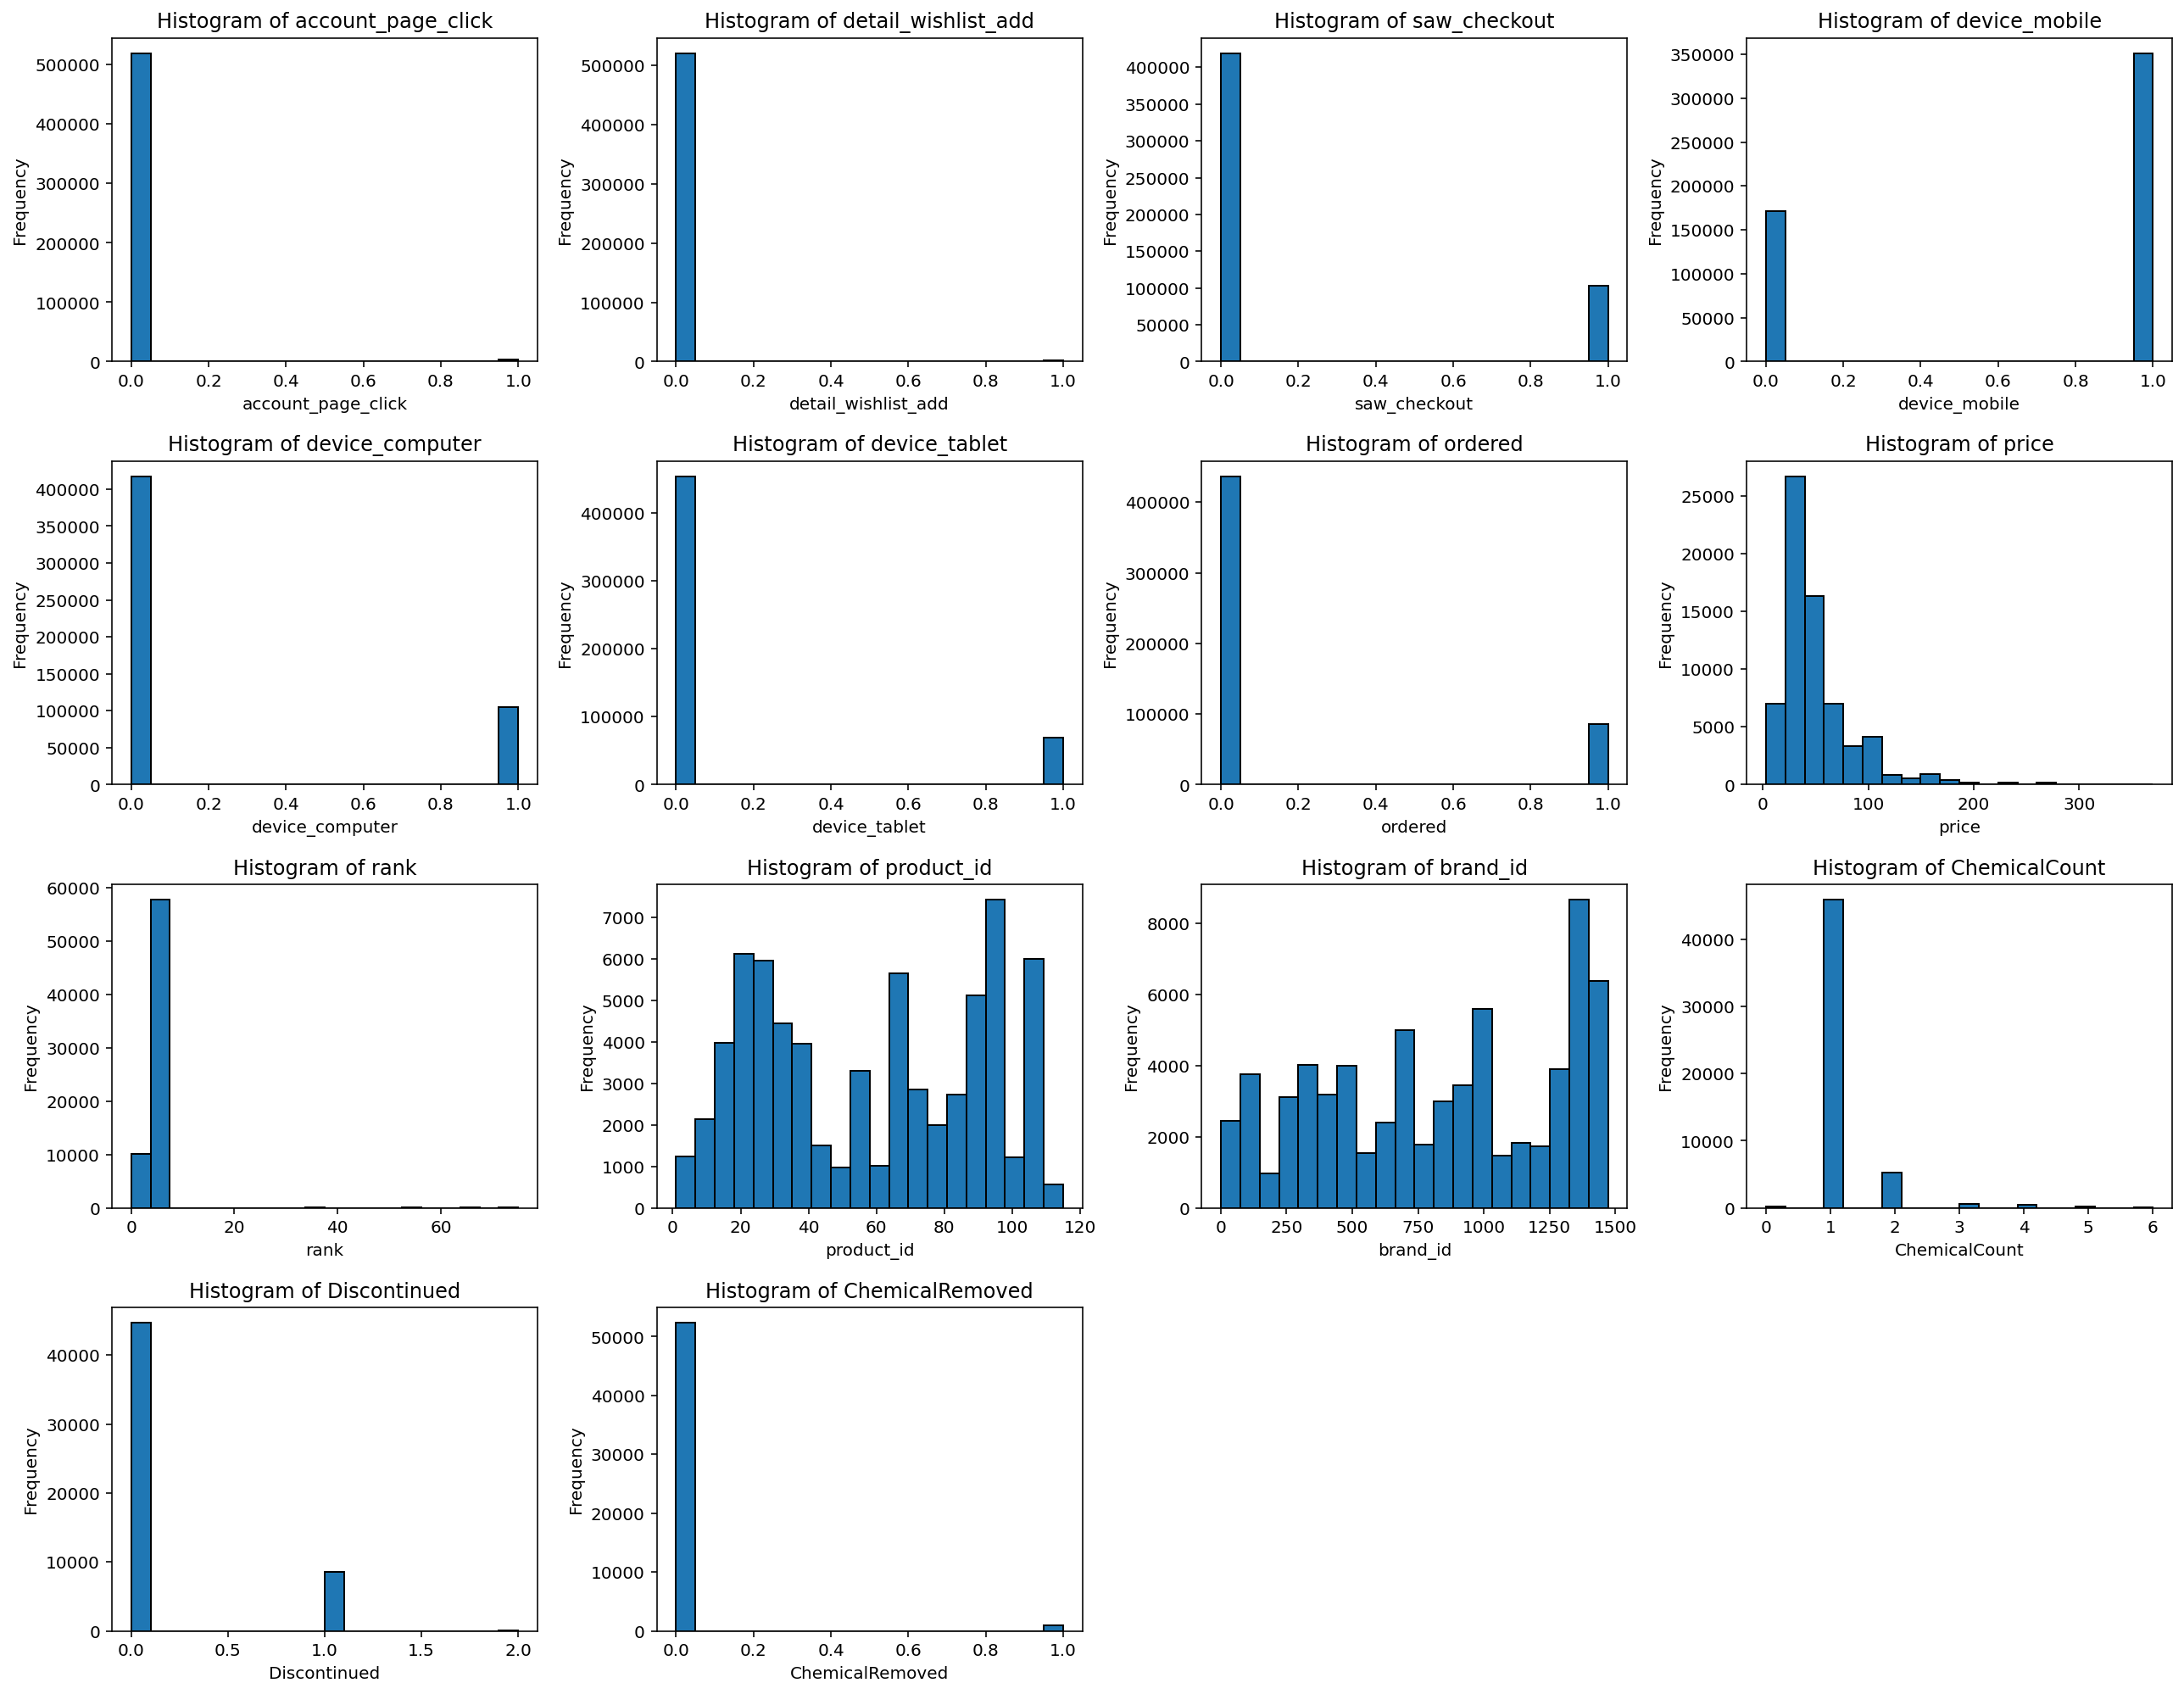

In [65]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_old_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

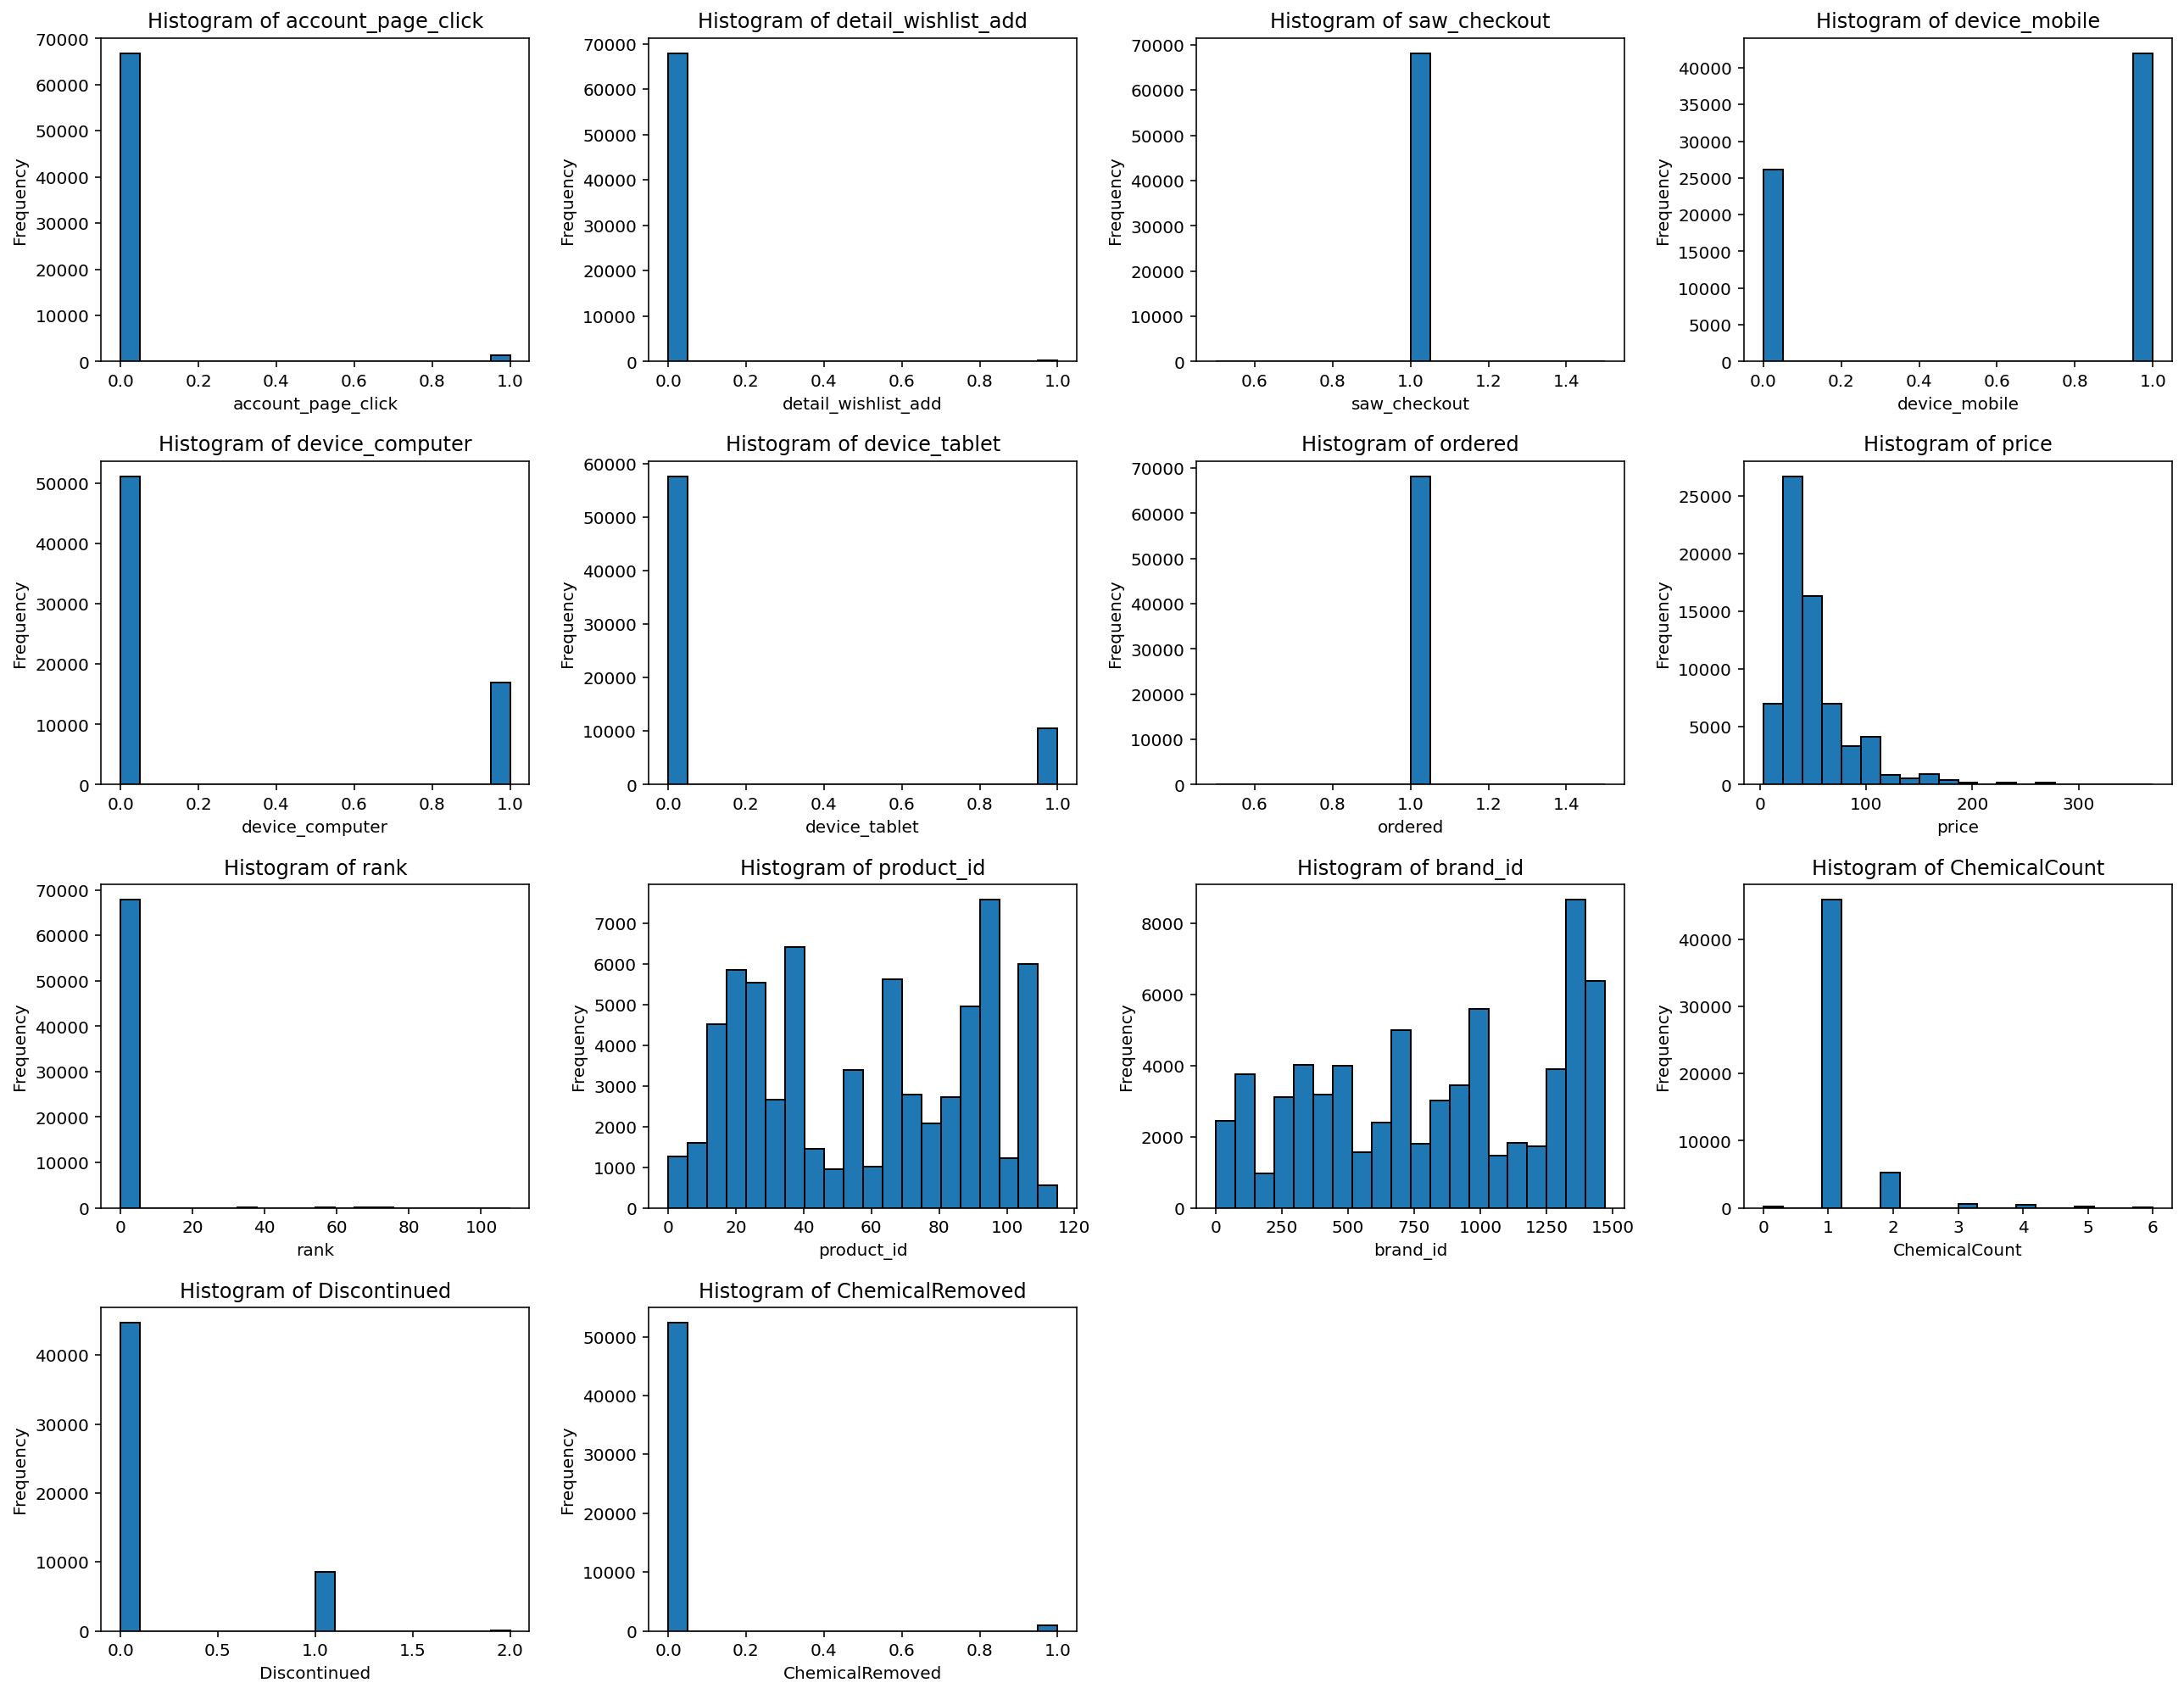

In [66]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

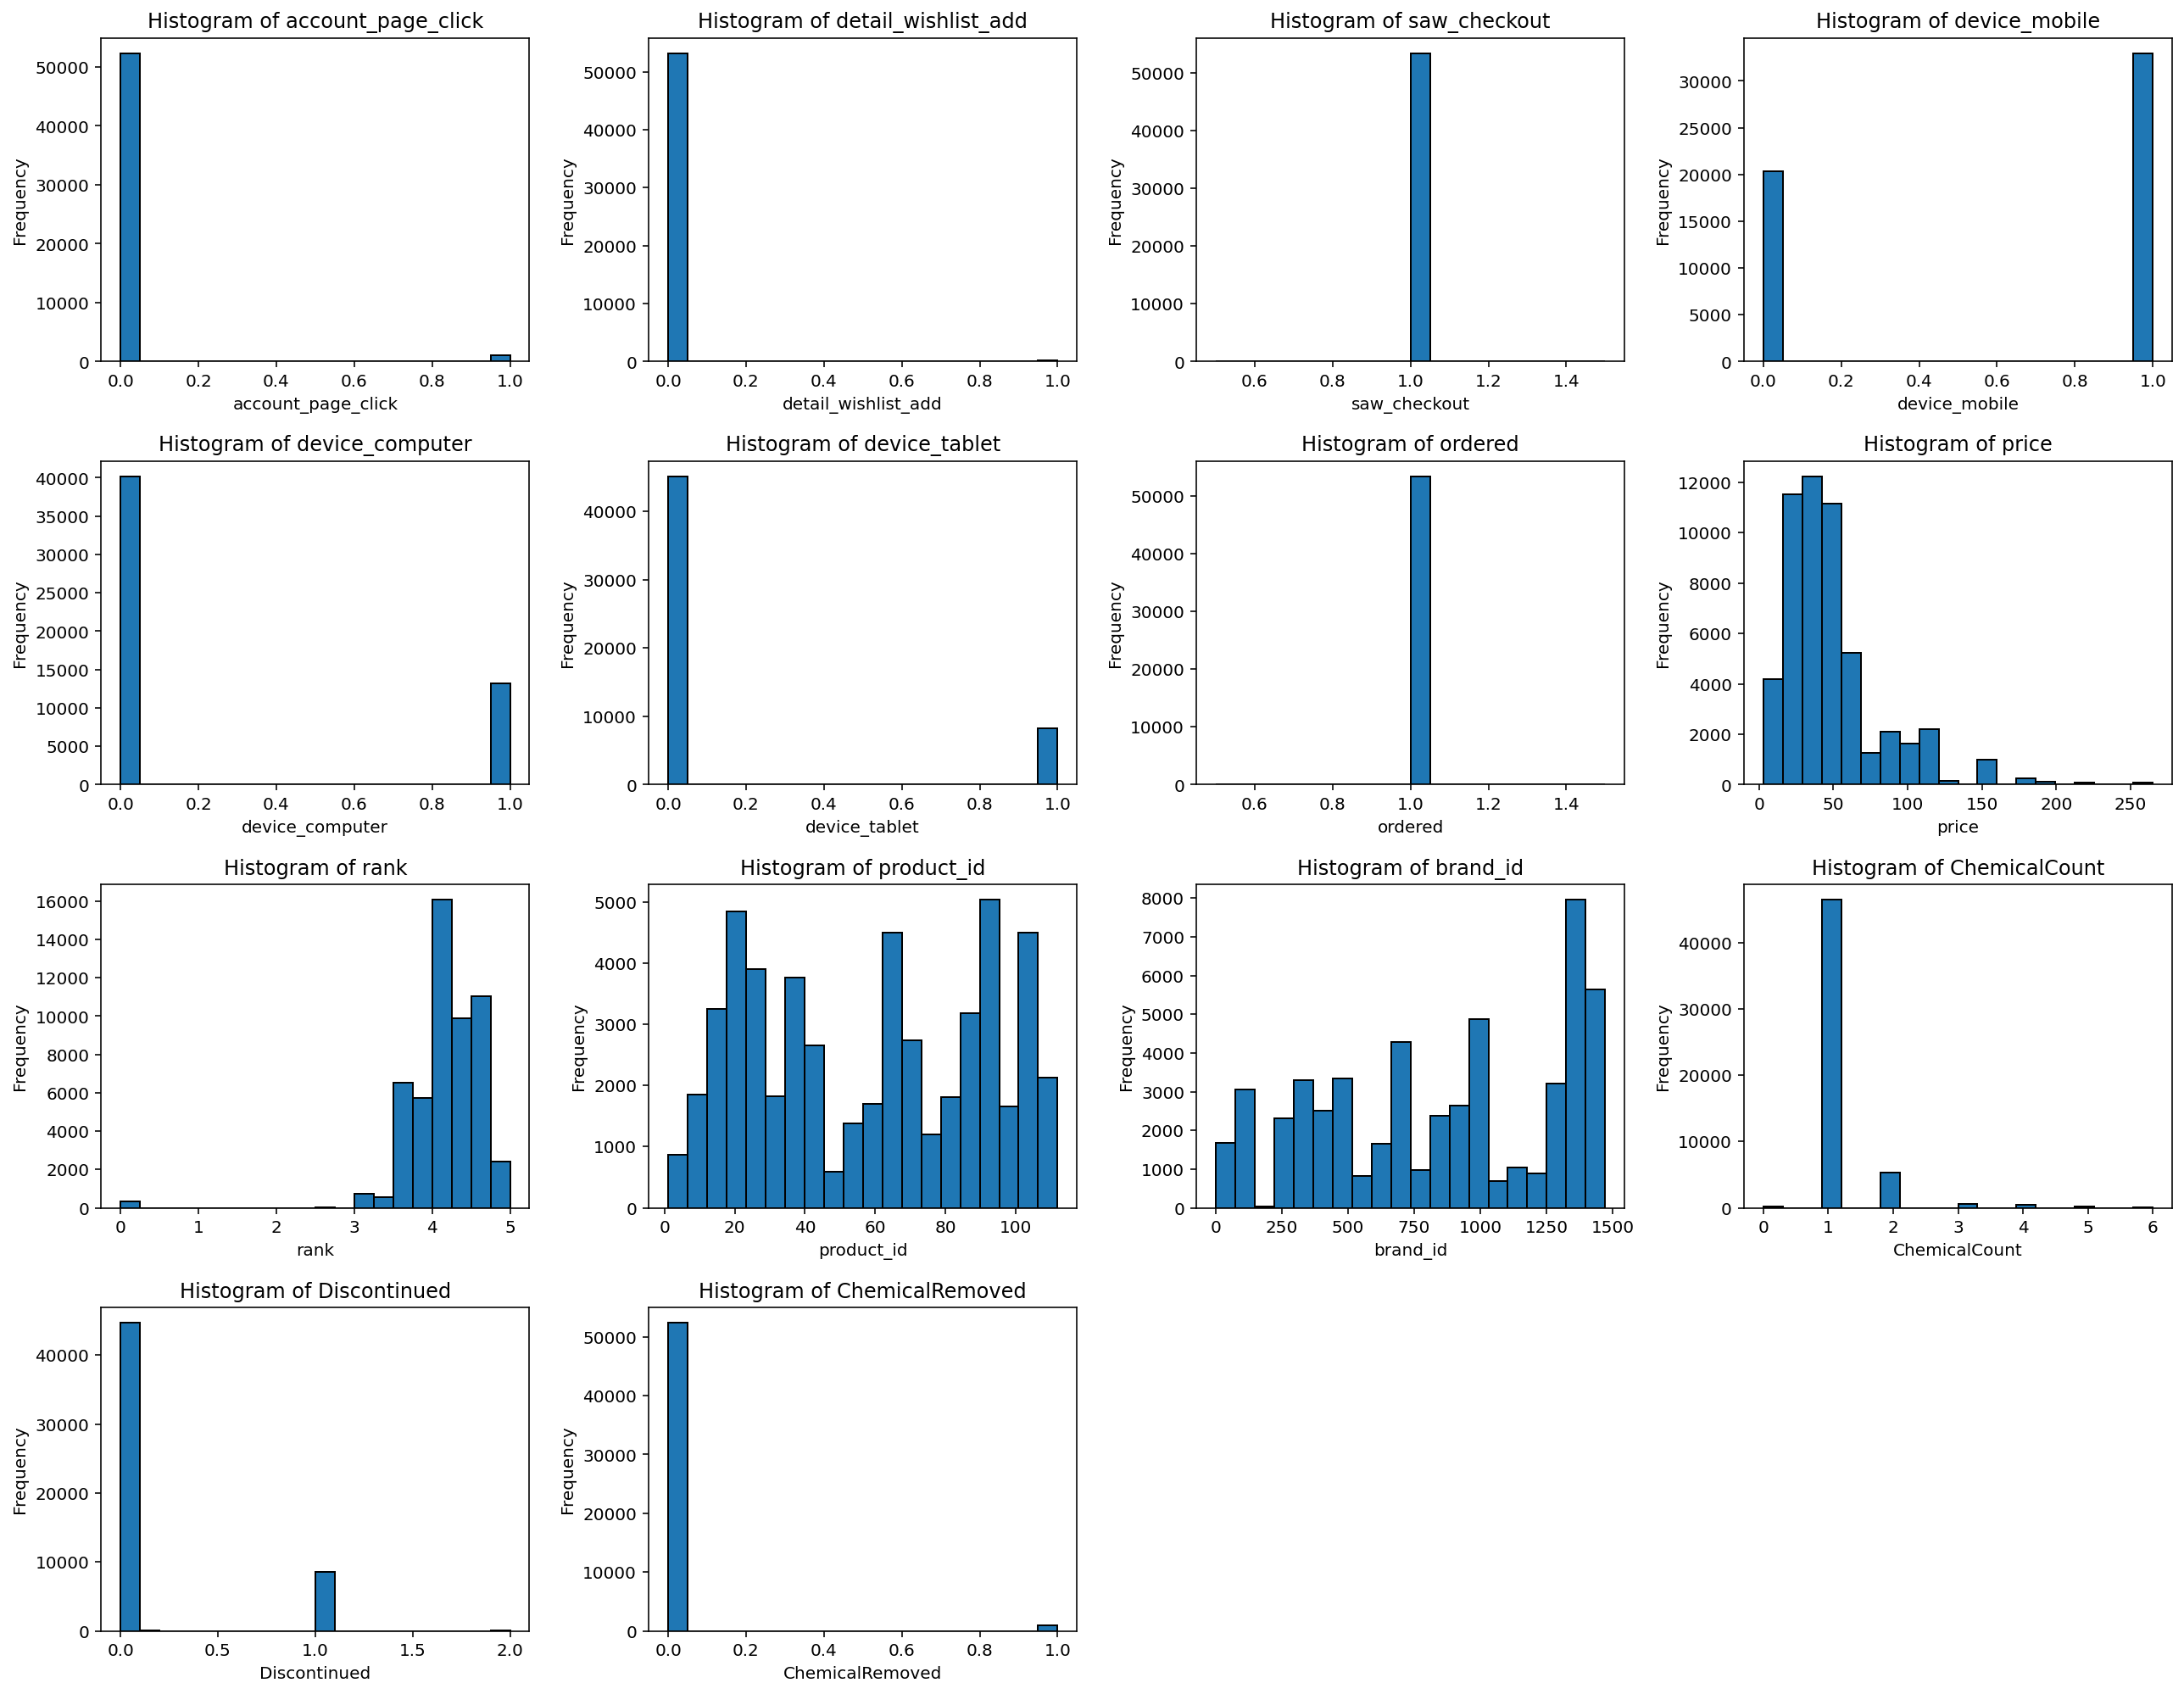

In [67]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df2[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

#### Box Plots

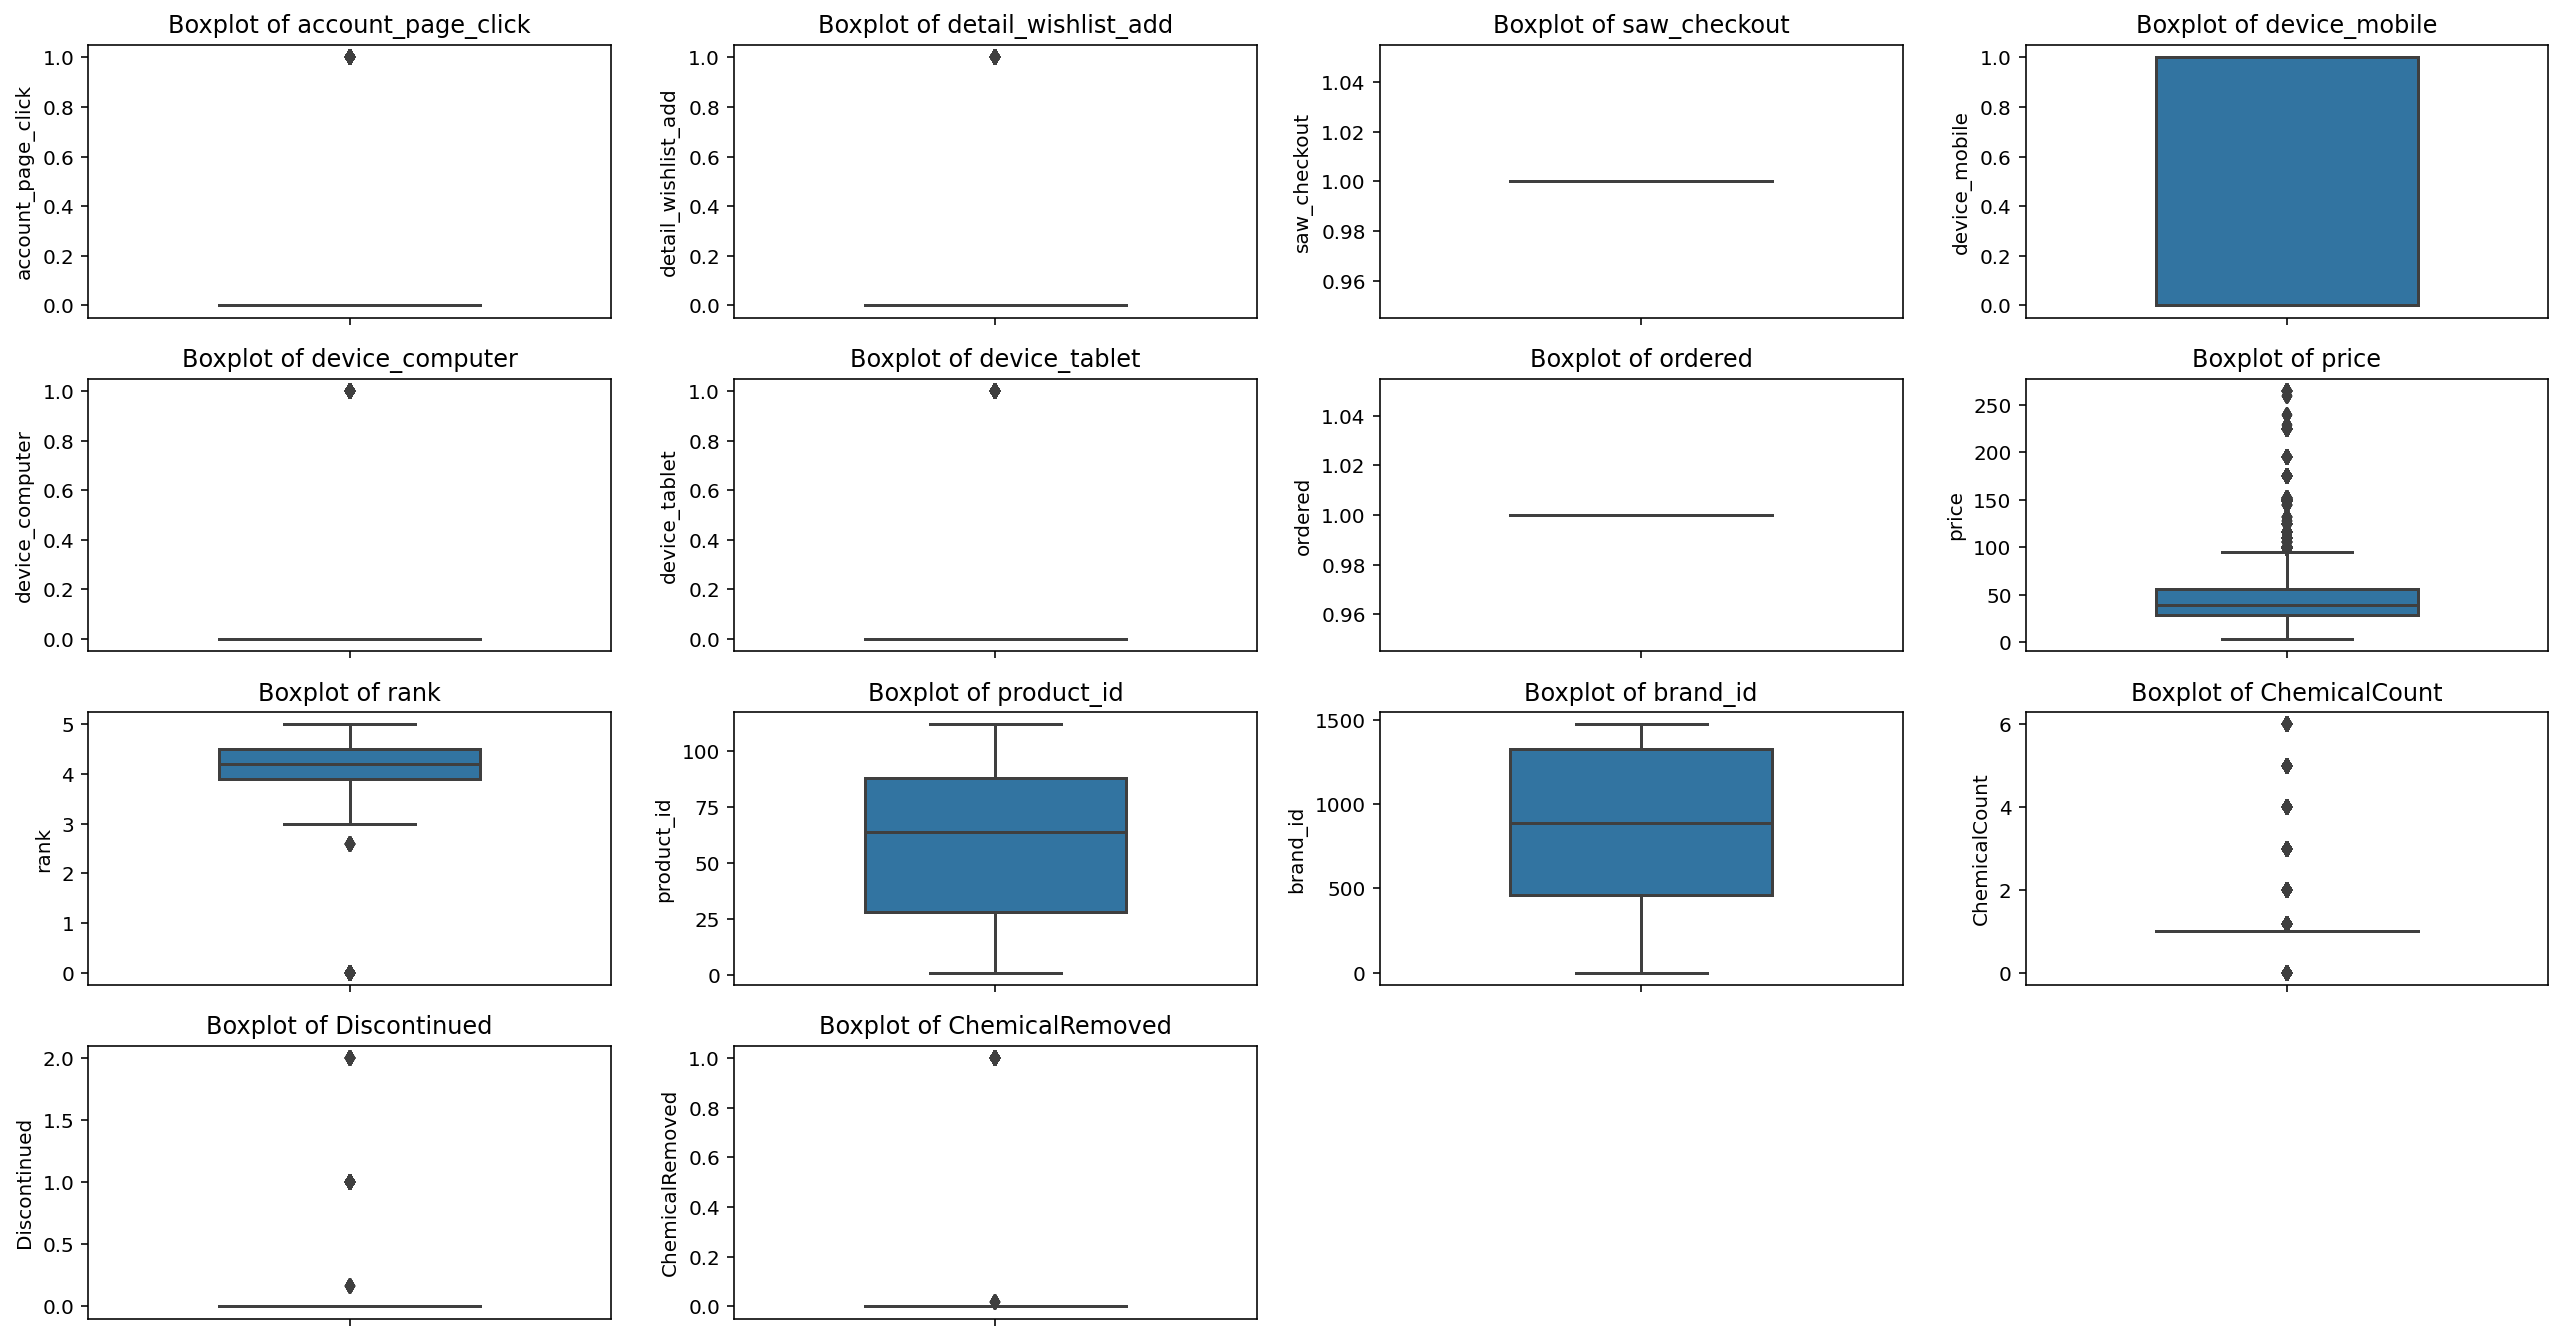

In [68]:
# list numerical predictors to create boxplots 
predictors = numerical_predictors = [
    'account_page_click','detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure for boxplots subplots 
plt.figure(figsize=(18, 14))  

# create boxplots for each predictor
for i, predictor in enumerate(predictors):
    plt.subplot(6, 4, i + 1)  
    sns.boxplot(data=sc_df2, y=predictor, width=0.5)
    plt.title(f'Boxplot of {predictor}')
    plt.ylabel(predictor)

plt.tight_layout()  
plt.show()

#### Bar Plots 

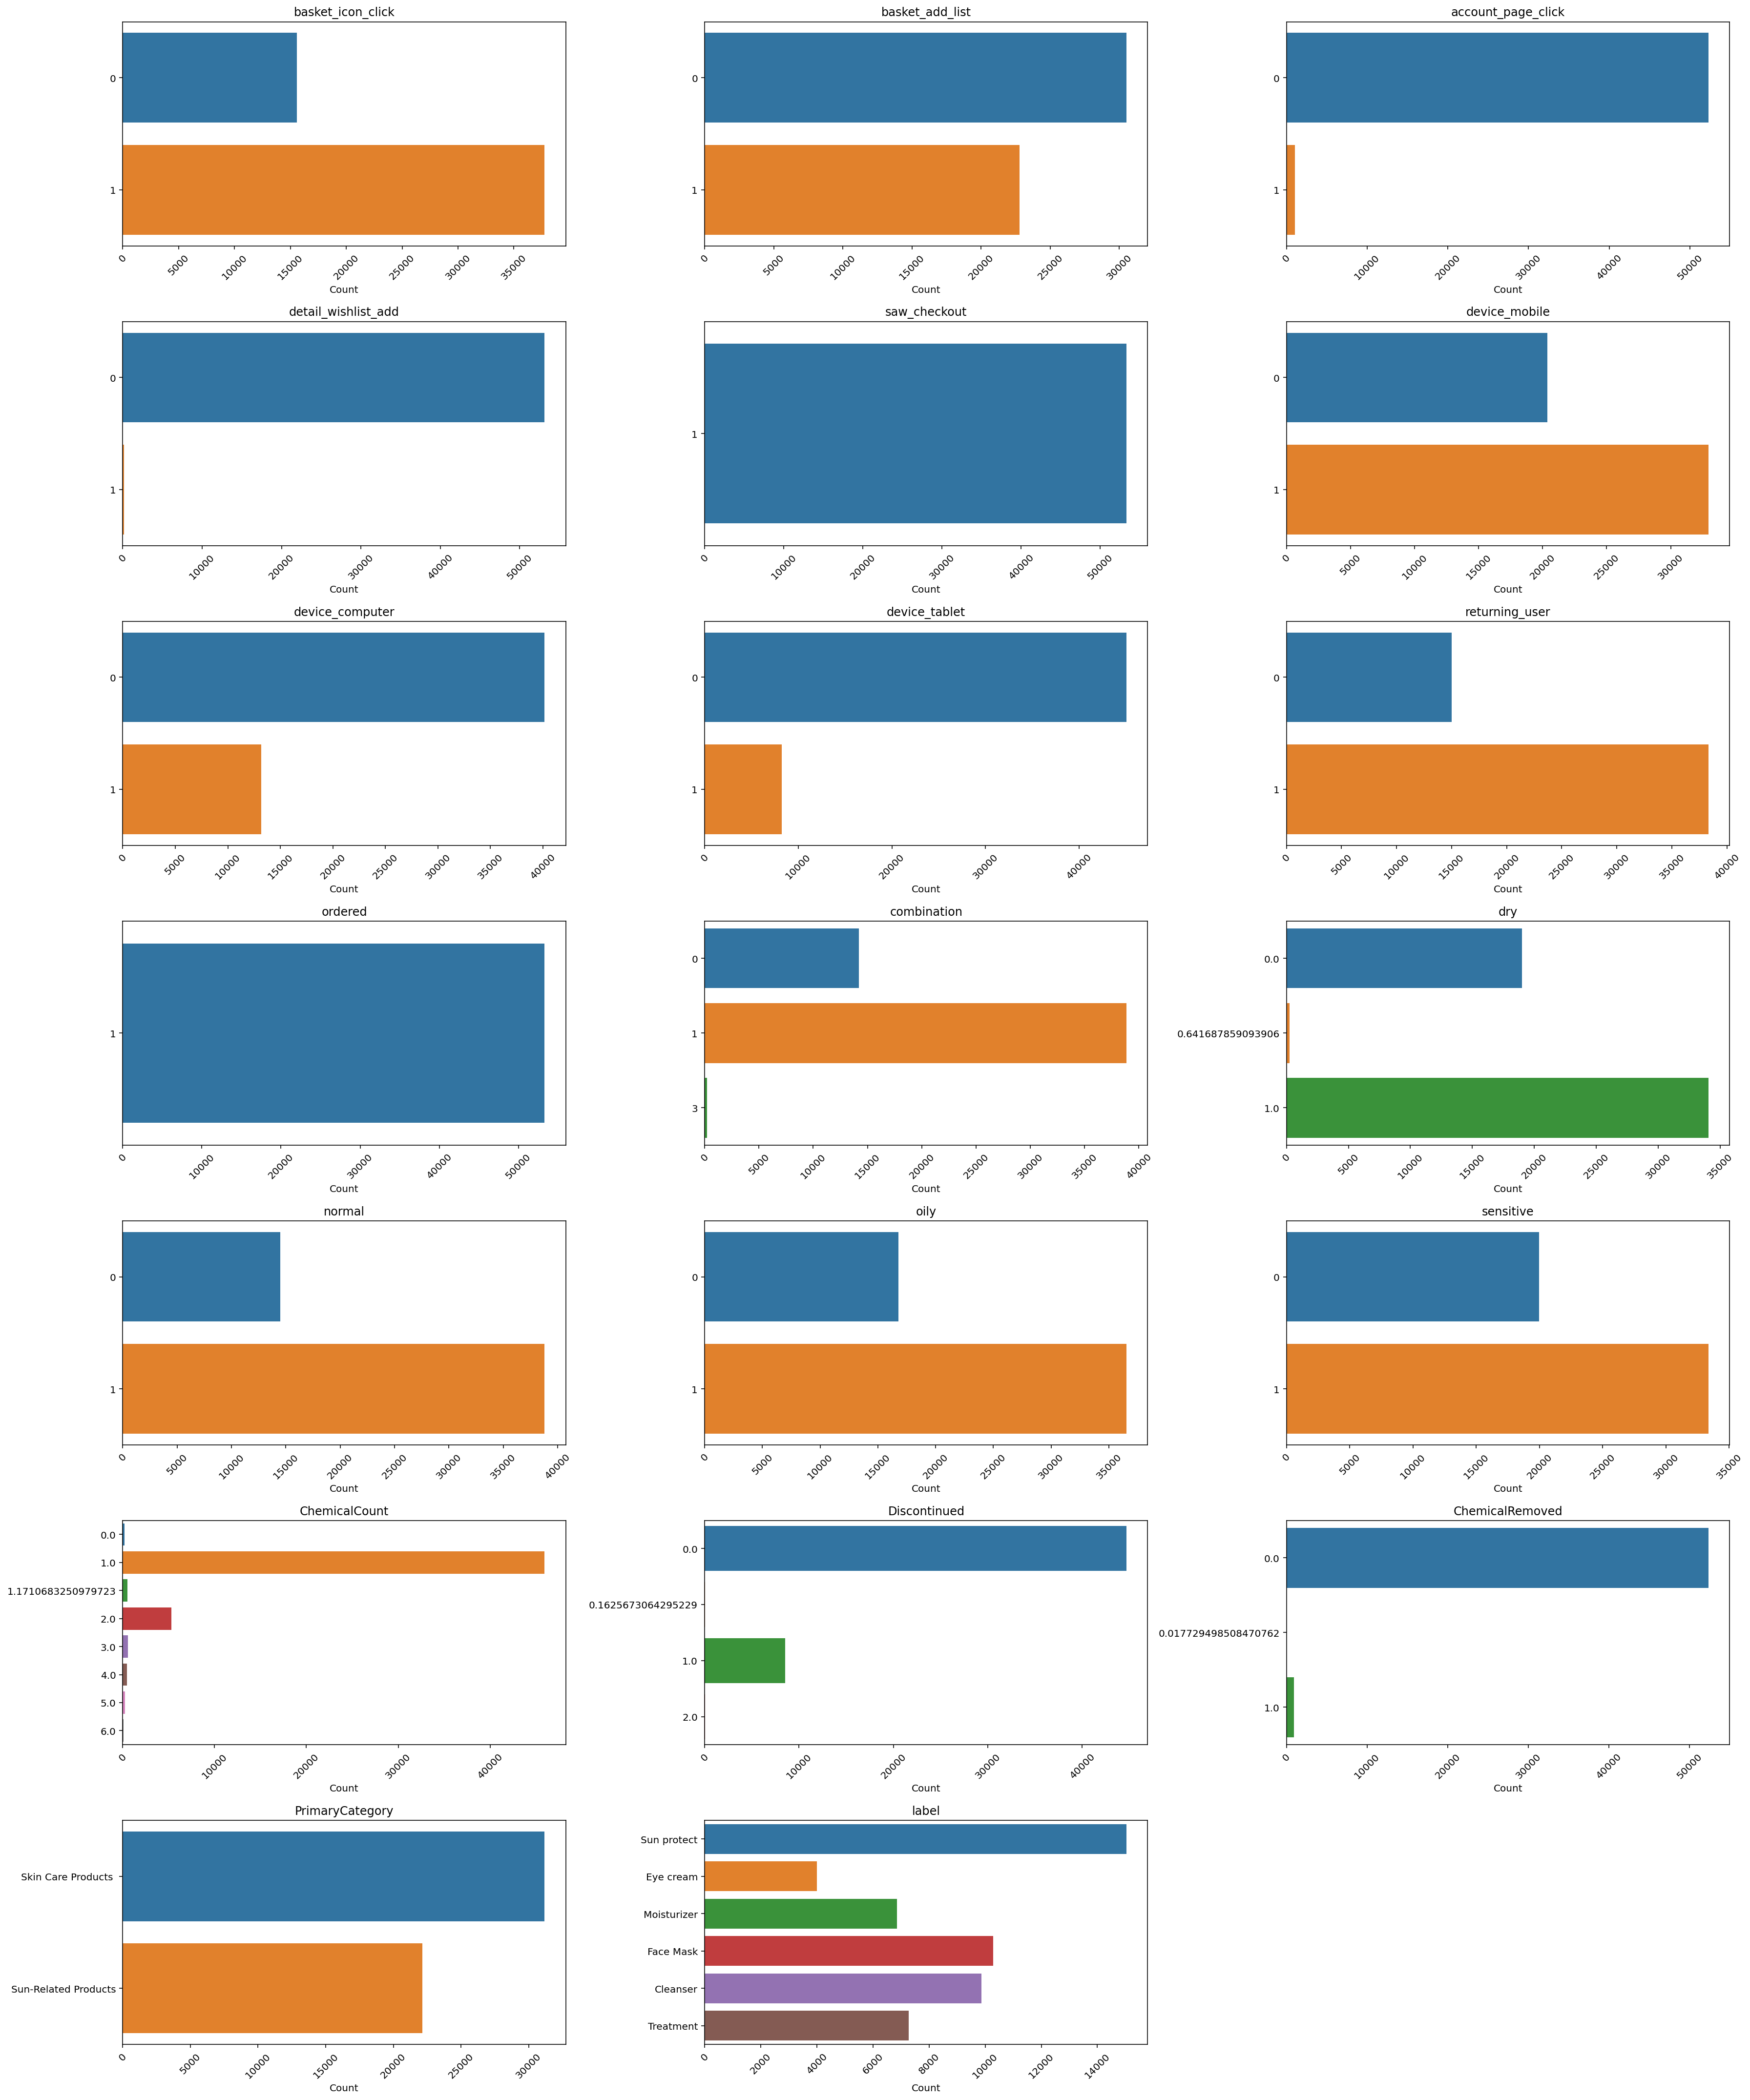

In [69]:
# list of selected columns for bar plot 
selected_columns = [
    'basket_icon_click', 'basket_add_list', 'account_page_click', 
    'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'returning_user', 
    'ordered', 'combination', 'dry', 'normal', 'oily', 'sensitive', 
    'ChemicalCount', 'Discontinued', 'ChemicalRemoved','PrimaryCategory', 'label'
]

# calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (len(selected_columns) - 1) // num_cols + 1

# create subplots and flatten axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))
axes = axes.flatten()

# iterate through selected columns and create horizontal countplots
for i, column in enumerate(selected_columns):
    sns.countplot(data=sc_df2, y=column, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  

    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# remove empty subplots
for i in range(len(selected_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**** Combine chemical counts, 0, 1, 2 3+ more (includeing 3, 5, 6) and fix columns with 0.0000... rows 

#### Class Imbalance 
#### ('ordered' and 'saw_checkout')

In [70]:
# check distribution of classes before adding class
print("\nBefore balancing:")
print(sc_df2['ordered'].value_counts())
print(sc_df2['saw_checkout'].value_counts())


Before balancing:
1    53325
Name: ordered, dtype: int64
1    53325
Name: saw_checkout, dtype: int64


In [112]:
# shuffle df to ensure randomness
sc_shuffled = sc_df2.sample(frac=1, random_state=42)

# define columns to balance 
columns_to_balance = ['ordered', 'saw_checkout']

# define threshold for chemical count to determine class imbalance
chemical_count_threshold = 1

# calculate the number of records to change for "ordered" class 1
num_records_to_change_ordered = int(len(sc_shuffled[(sc_shuffled['ordered'] == 1) & (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)]))

# select records where "ordered" = 1 and chemical count does not exceed the threshold
records_to_change_ordered = sc_shuffled[(sc_shuffled['ordered'] == 1) & (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)].head(num_records_to_change_ordered)
records_to_change_ordered['ordered'] = 0
sc_shuffled.loc[records_to_change_ordered.index, 'ordered'] = records_to_change_ordered['ordered']

# calculate number of records for "saw_checkout" class 1 to maintain 40% balance
num_records_to_change_saw_checkout = int(len(sc_shuffled[sc_shuffled['saw_checkout'] == 1]) * 0.4)
records_to_change_saw_checkout = sc_shuffled[sc_shuffled['saw_checkout'] == 1].head(num_records_to_change_saw_checkout)
records_to_change_saw_checkout['saw_checkout'] = 0

# update df 
sc_shuffled.loc[records_to_change_saw_checkout.index, 'saw_checkout'] = records_to_change_saw_checkout['saw_checkout']

In [119]:
# chemical count threshold FIX IT 

In [113]:
# check distribution of classes after adding class
print("\nAfter balancing:")
print(sc_shuffled ['ordered'].value_counts())
print(sc_shuffled ['saw_checkout'].value_counts())


After balancing:
0    46161
1     7164
Name: ordered, dtype: int64
1    31995
0    21330
Name: saw_checkout, dtype: int64


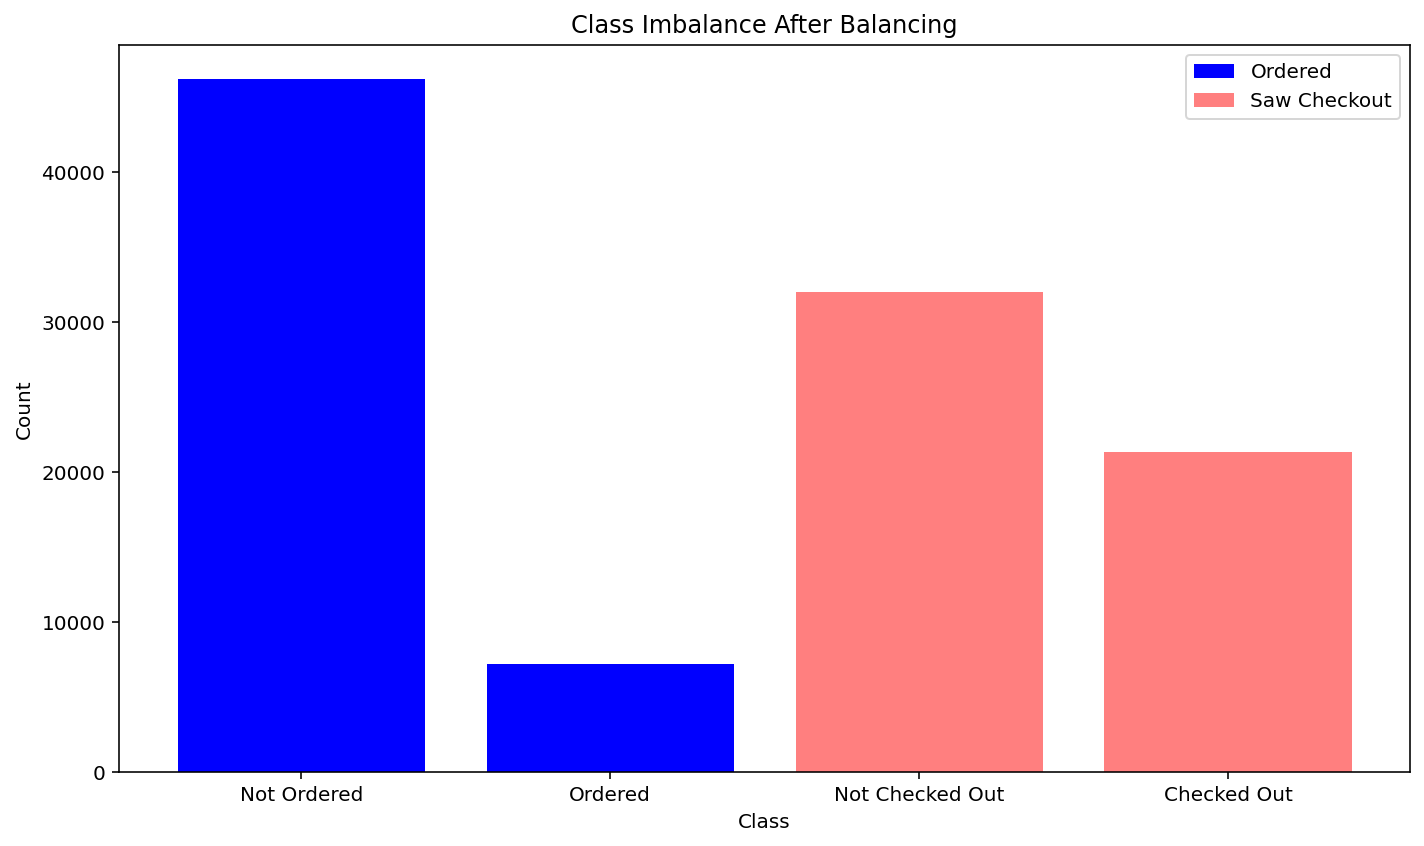

In [73]:
plt.figure(figsize=(10, 6))

# Bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], sc_shuffled['ordered'].value_counts(), color='blue', label='Ordered')

# Bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], sc_shuffled['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After Balancing')
plt.legend()
plt.tight_layout()

plt.show()

In [74]:
checkout_distribution = sc_shuffled['saw_checkout'].value_counts(normalize=True)
print("Class Distribution for Saw Check Out:\n", checkout_distribution)

ordered_distribution = sc_shuffled['ordered'].value_counts(normalize=True)
print("Class Distribution for Ordered:\n", ordered_distribution)

Class Distribution for Saw Check Out:
 1    0.6
0    0.4
Name: saw_checkout, dtype: float64
Class Distribution for Ordered:
 0    0.865654
1    0.134346
Name: ordered, dtype: float64


In [75]:
balanced_df = sc_shuffled.copy()
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53325 entries, 31078 to 15795
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               53325 non-null  object 
 1   basket_icon_click    53325 non-null  int64  
 2   basket_add_list      53325 non-null  int64  
 3   account_page_click   53325 non-null  int64  
 4   detail_wishlist_add  53325 non-null  int64  
 5   saw_checkout         53325 non-null  int64  
 6   device_mobile        53325 non-null  int64  
 7   device_computer      53325 non-null  int64  
 8   device_tablet        53325 non-null  int64  
 9   returning_user       53325 non-null  int64  
 10  ordered              53325 non-null  int64  
 11  label                53325 non-null  object 
 12  brand                53325 non-null  object 
 13  name                 53325 non-null  object 
 14  price                53325 non-null  float64
 15  rank                 53325 non-n

The decrease in data size post-SMOTE arises from the generation of synthetic samples to balance class distribution. SMOTE may remove or undersample instances to prevent overfitting and maintain a balanced representation of minority and majority classes, ensuring effective synthesis while preserving dataset integrity.

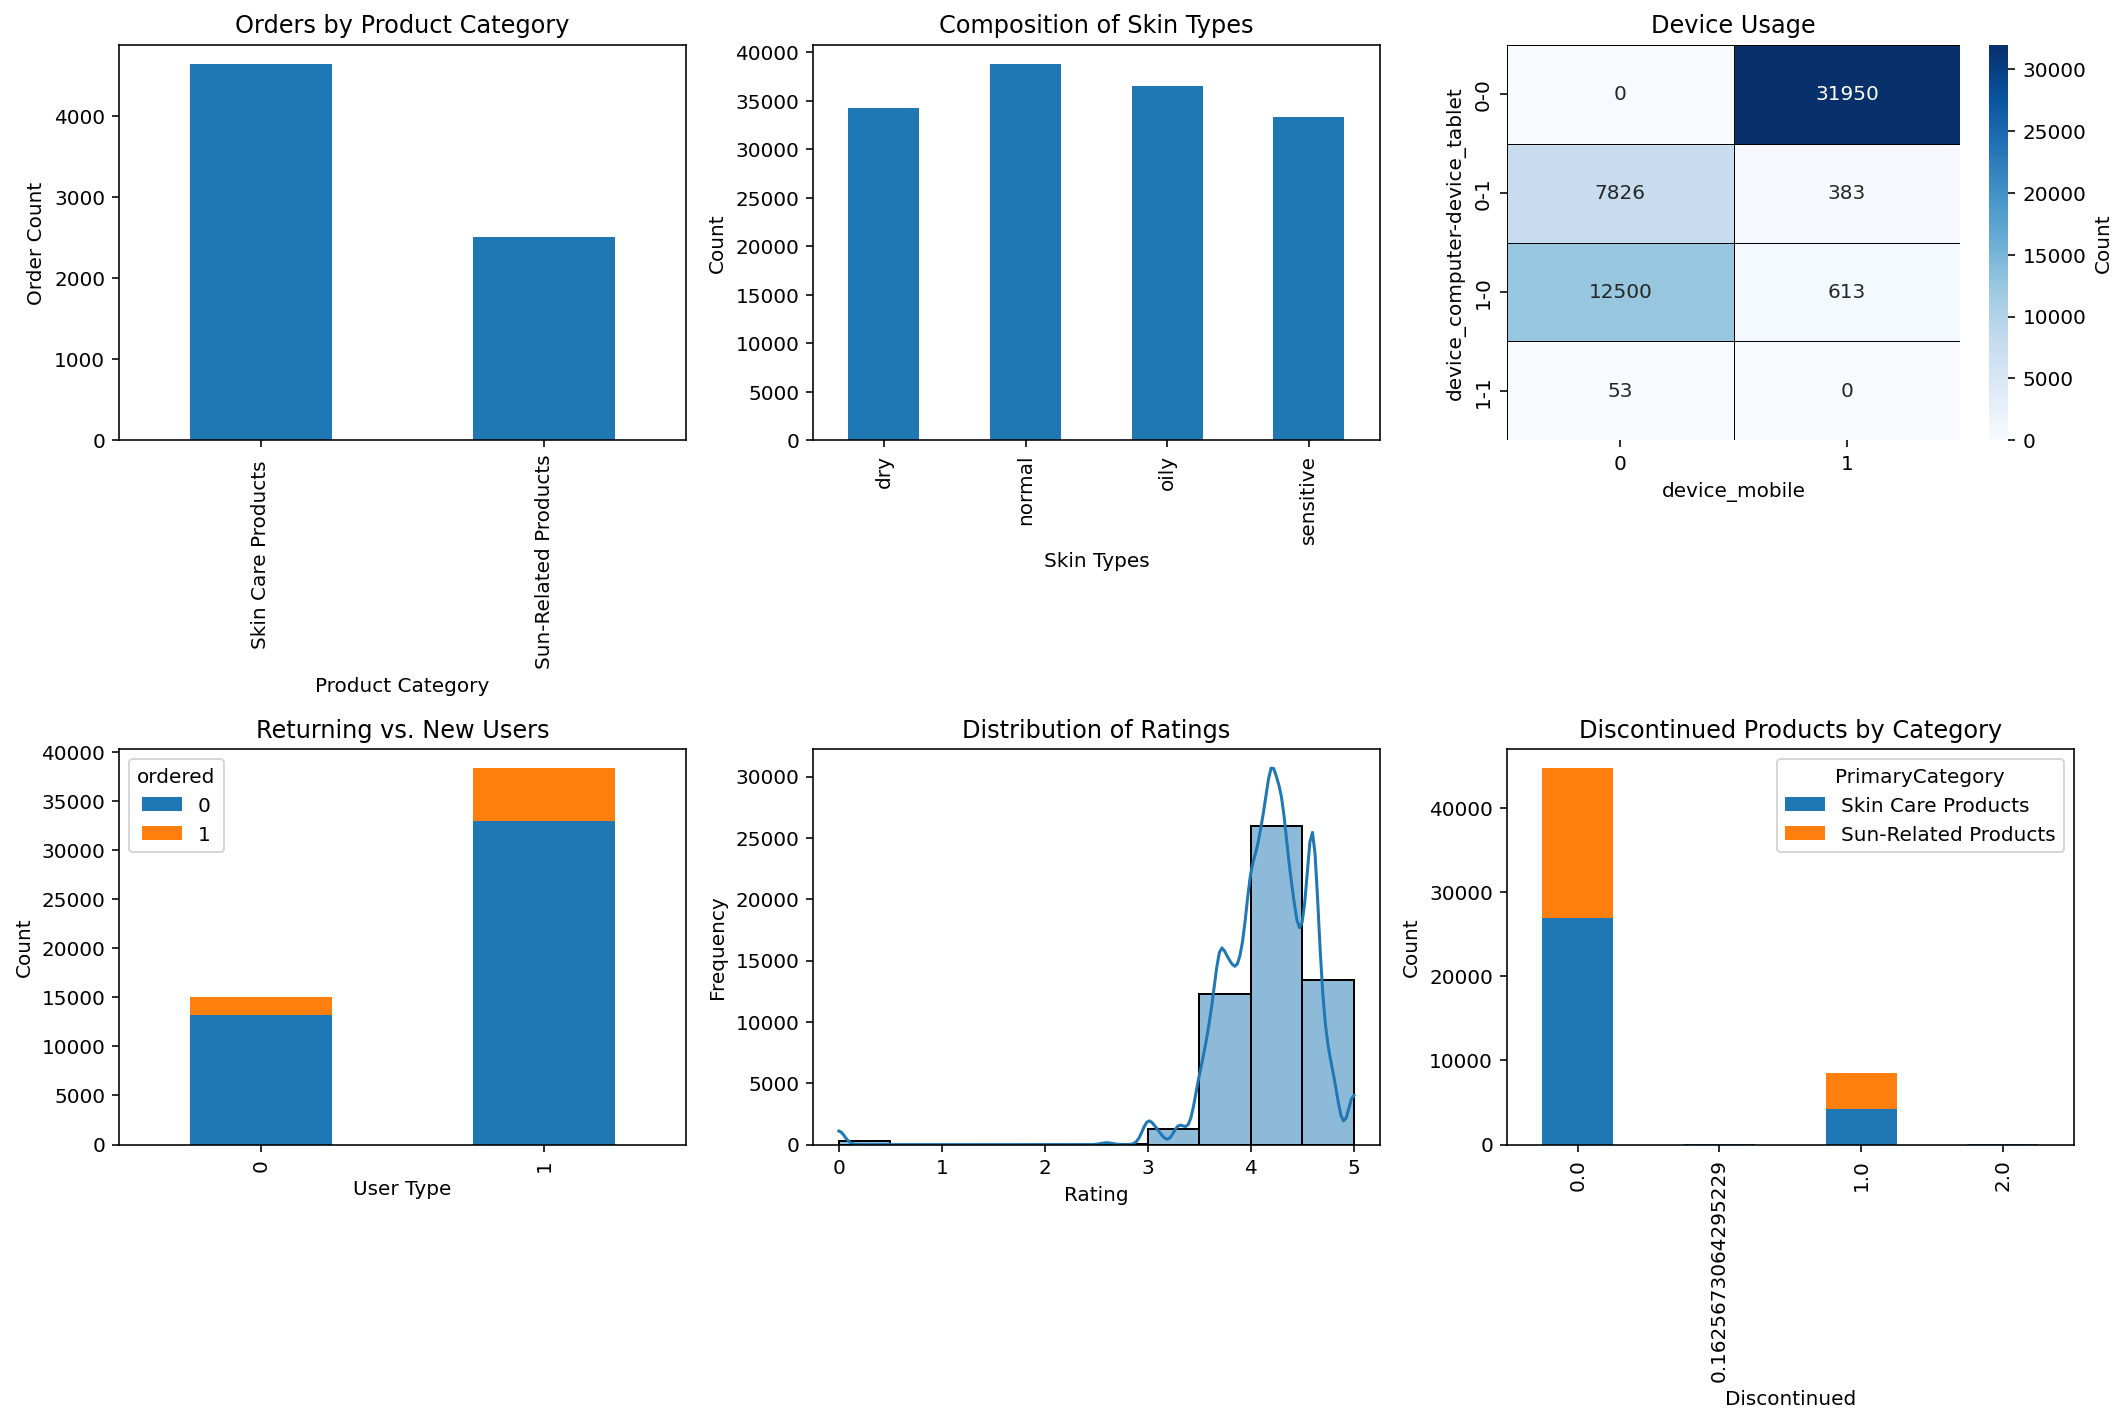

In [76]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# count of ordered by product category
order_count_by_category = balanced_df.groupby('PrimaryCategory')['ordered'].sum()
order_count_by_category.plot(kind='bar', ax=axs[0, 0], 
                             xlabel='Product Category', ylabel='Order Count', 
                             title='Orders by Product Category')

# composition of skin types
skin_type_counts = balanced_df[['dry', 'normal', 'oily', 'sensitive']].sum()
skin_type_counts.plot(kind='bar', stacked=True, ax=axs[0, 1], 
                      xlabel='Skin Types', ylabel='Count', 
                      title='Composition of Skin Types')

# device usage 
device_usage = balanced_df[['device_computer', 'device_tablet', 'device_mobile']].astype(int)
device_usage_counts = device_usage.groupby(device_usage.columns.tolist()).size().unstack(fill_value=0)
sns.heatmap(device_usage_counts, ax=axs[0, 2], cmap="Blues", annot=True, fmt="d",
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='black')
axs[0, 2].set_title('Device Usage')

# returning vs new users 
returning_new_users = pd.crosstab(balanced_df['returning_user'], 
                                  balanced_df['ordered'])

returning_new_users.plot(kind='bar', stacked=True, ax=axs[1, 0], 
                         xlabel='User Type', ylabel='Count', 
                         title='Returning vs. New Users')

# distribution of ratings 
sns.histplot(data=balanced_df, x='rank', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Ratings')

# discontinued products 
discontinued_category_counts = pd.crosstab(index=balanced_df['Discontinued'], 
                                           columns=balanced_df['PrimaryCategory'])

discontinued_category_counts.plot(kind='bar', stacked=True, ax=axs[1, 2], 
                                  xlabel='Discontinued', ylabel='Count', 
                                  title='Discontinued Products by Category')

plt.tight_layout()
plt.show()

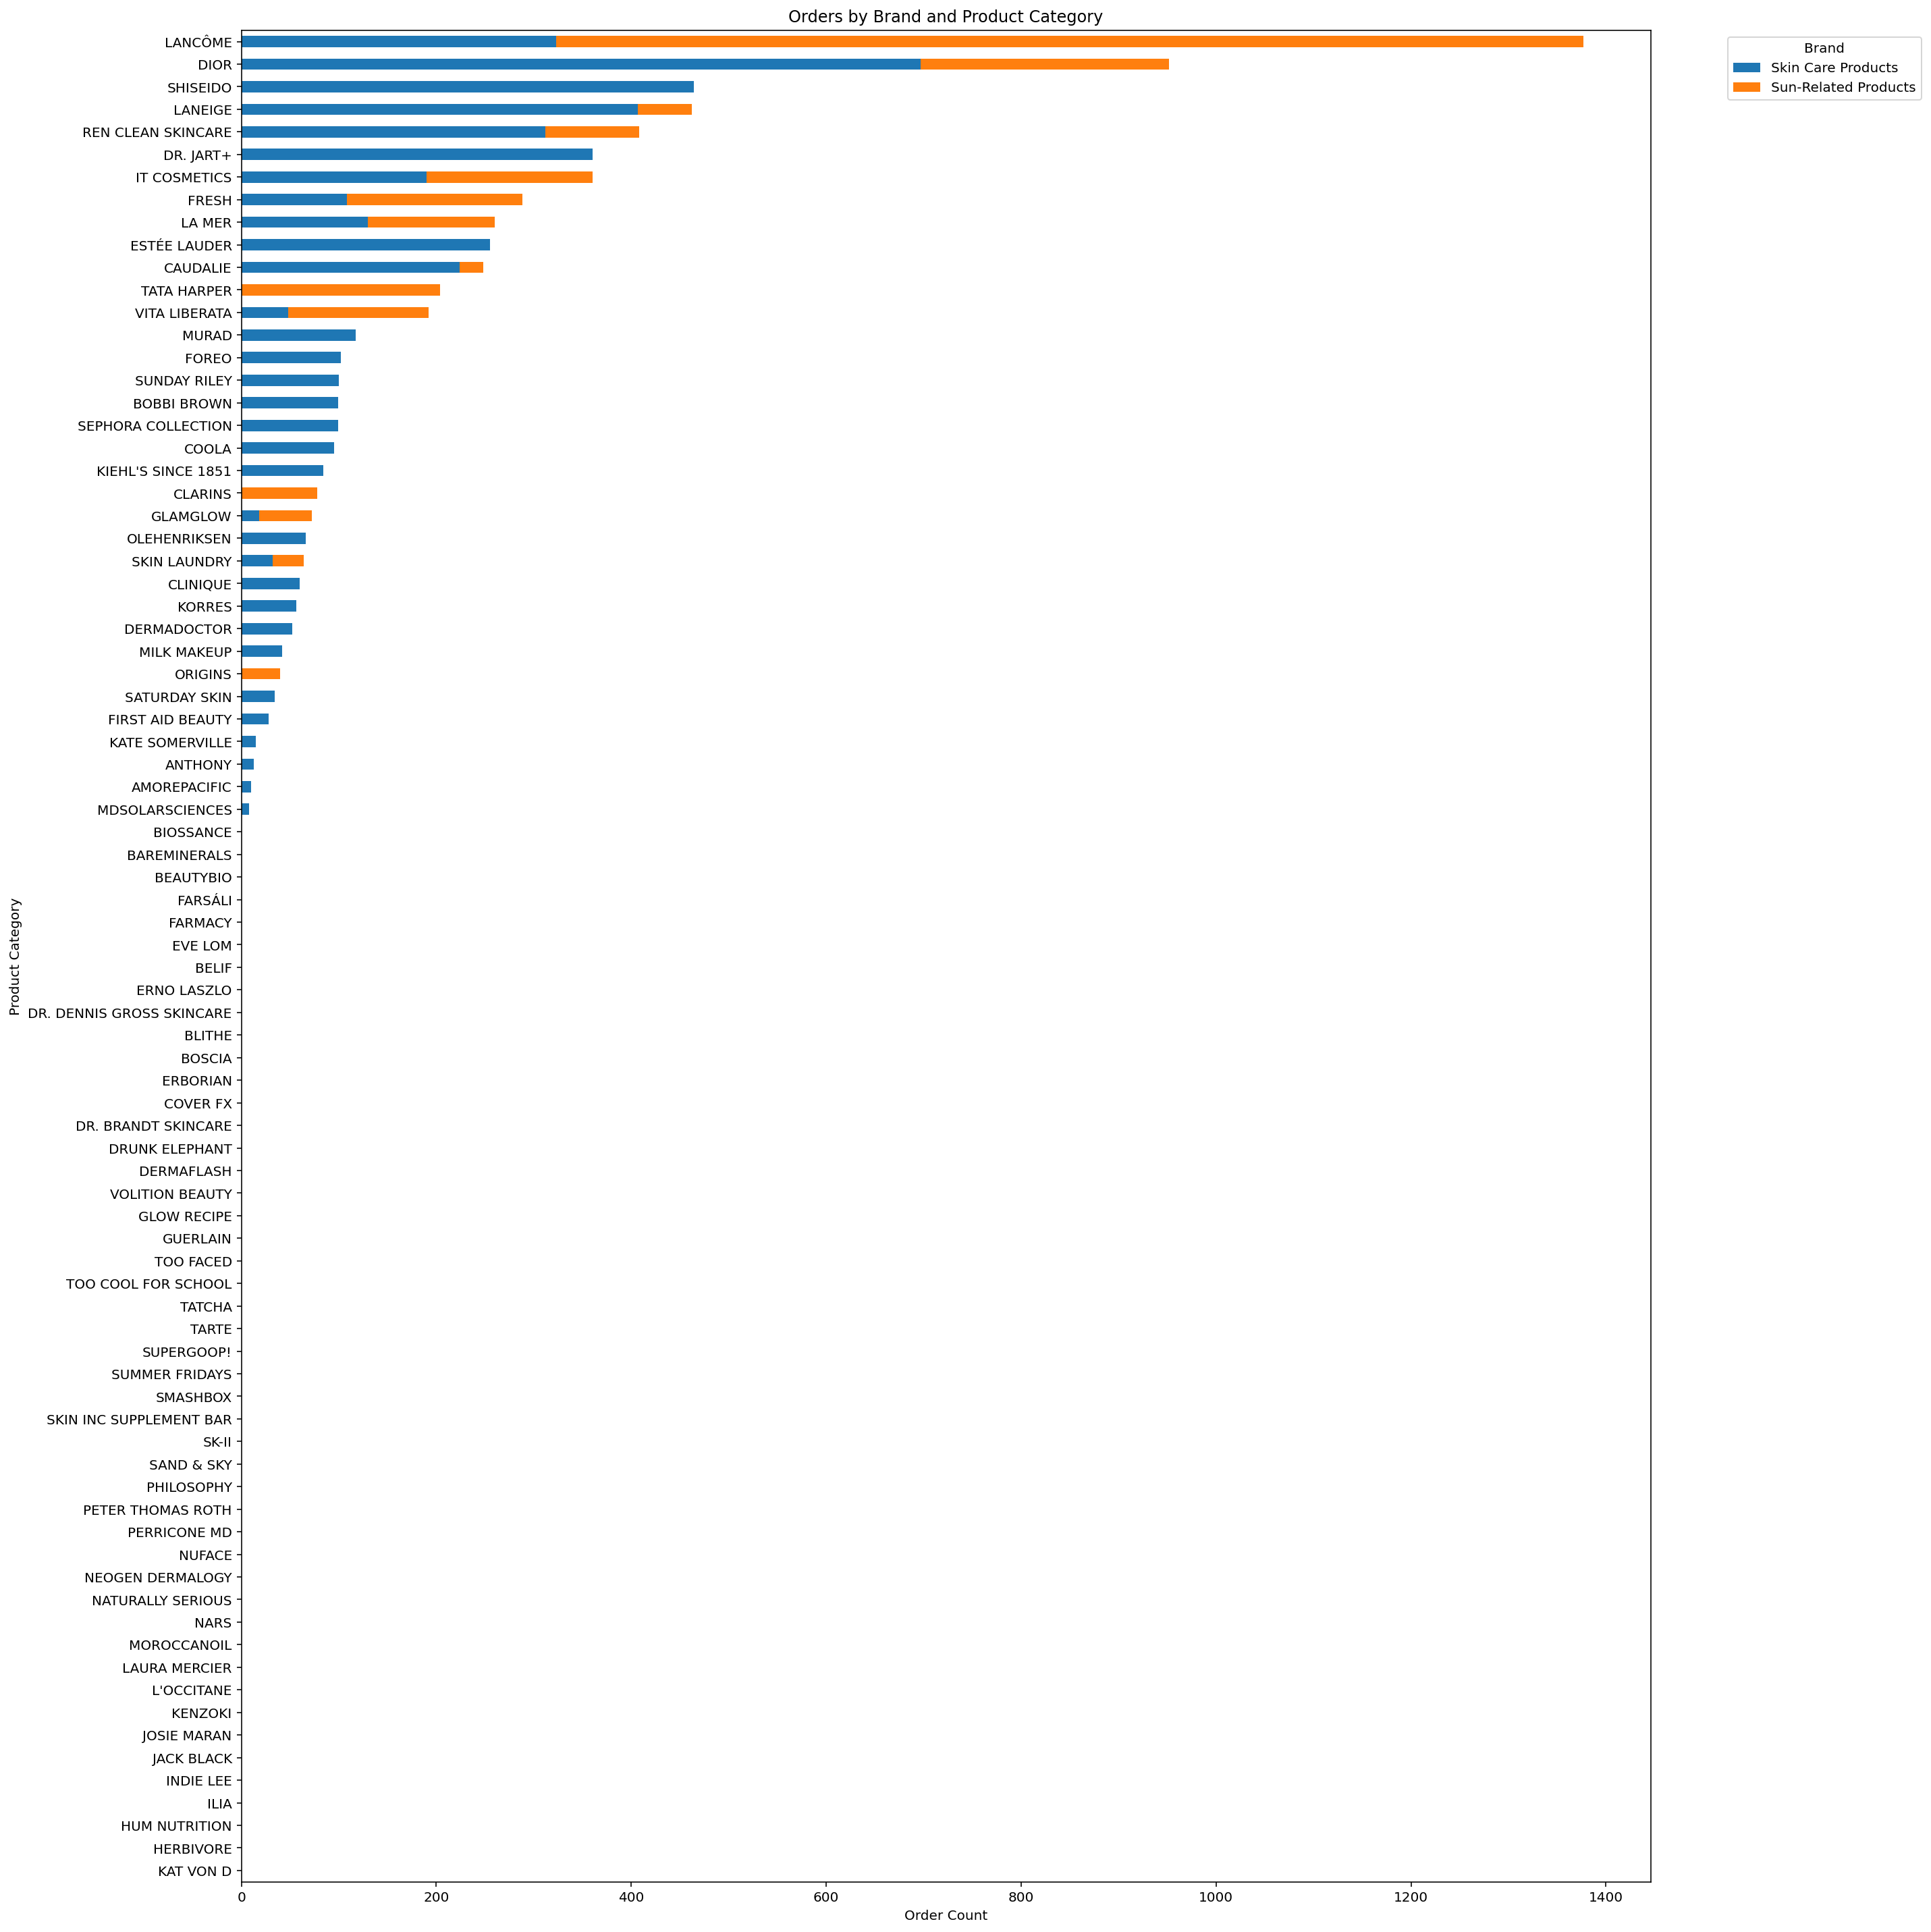

In [77]:
#  order count by brand and product category
order_count_by_brand_category = balanced_df.groupby(['brand', 'PrimaryCategory'])['ordered'].sum().unstack().fillna(0)
order_count_by_brand = order_count_by_brand_category.sum(axis=1).sort_values()
order_count_by_brand_category = order_count_by_brand_category.loc[order_count_by_brand.index]


order_count_by_brand_category.plot(kind='barh', stacked=True, figsize=(20, 20))
plt.xlabel('Order Count')
plt.ylabel('Product Category')
plt.title('Orders by Brand and Product Category')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

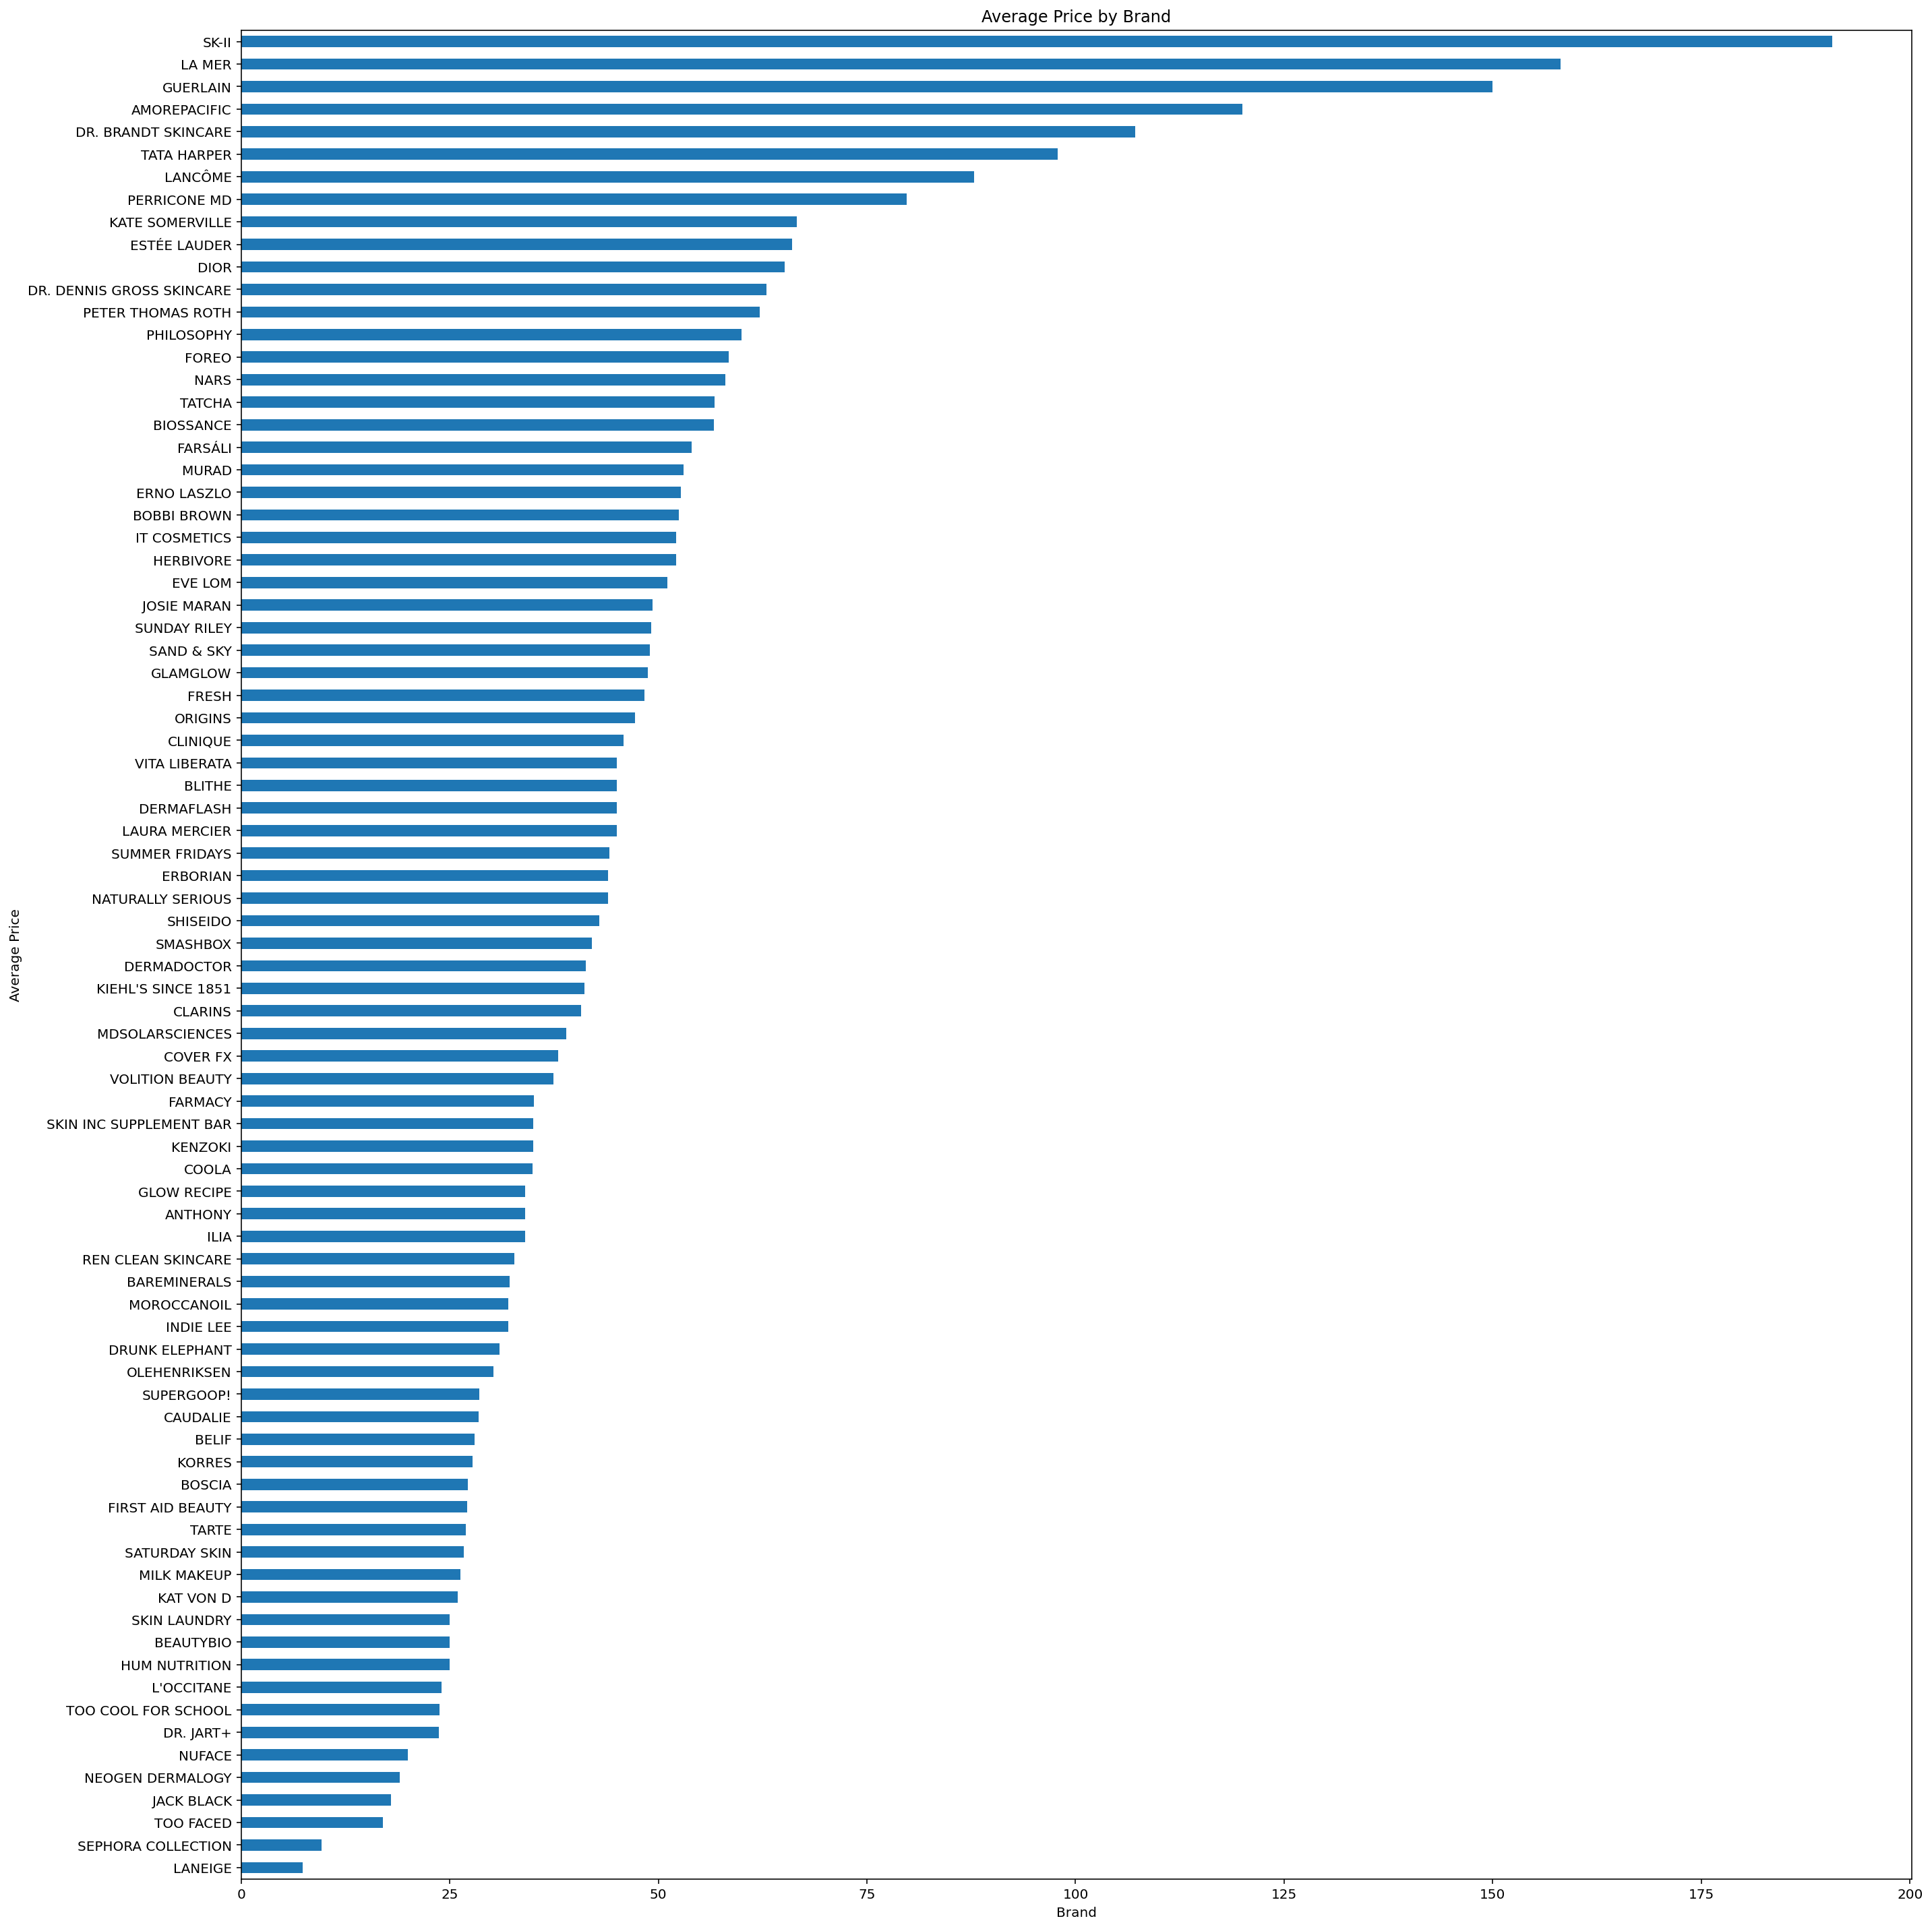

In [78]:
# plot the average price by brand
avg_price_by_brand = balanced_df.groupby('brand')['price'].mean().sort_values()

plt.figure(figsize=(20, 20))
avg_price_by_brand.plot(kind='barh')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

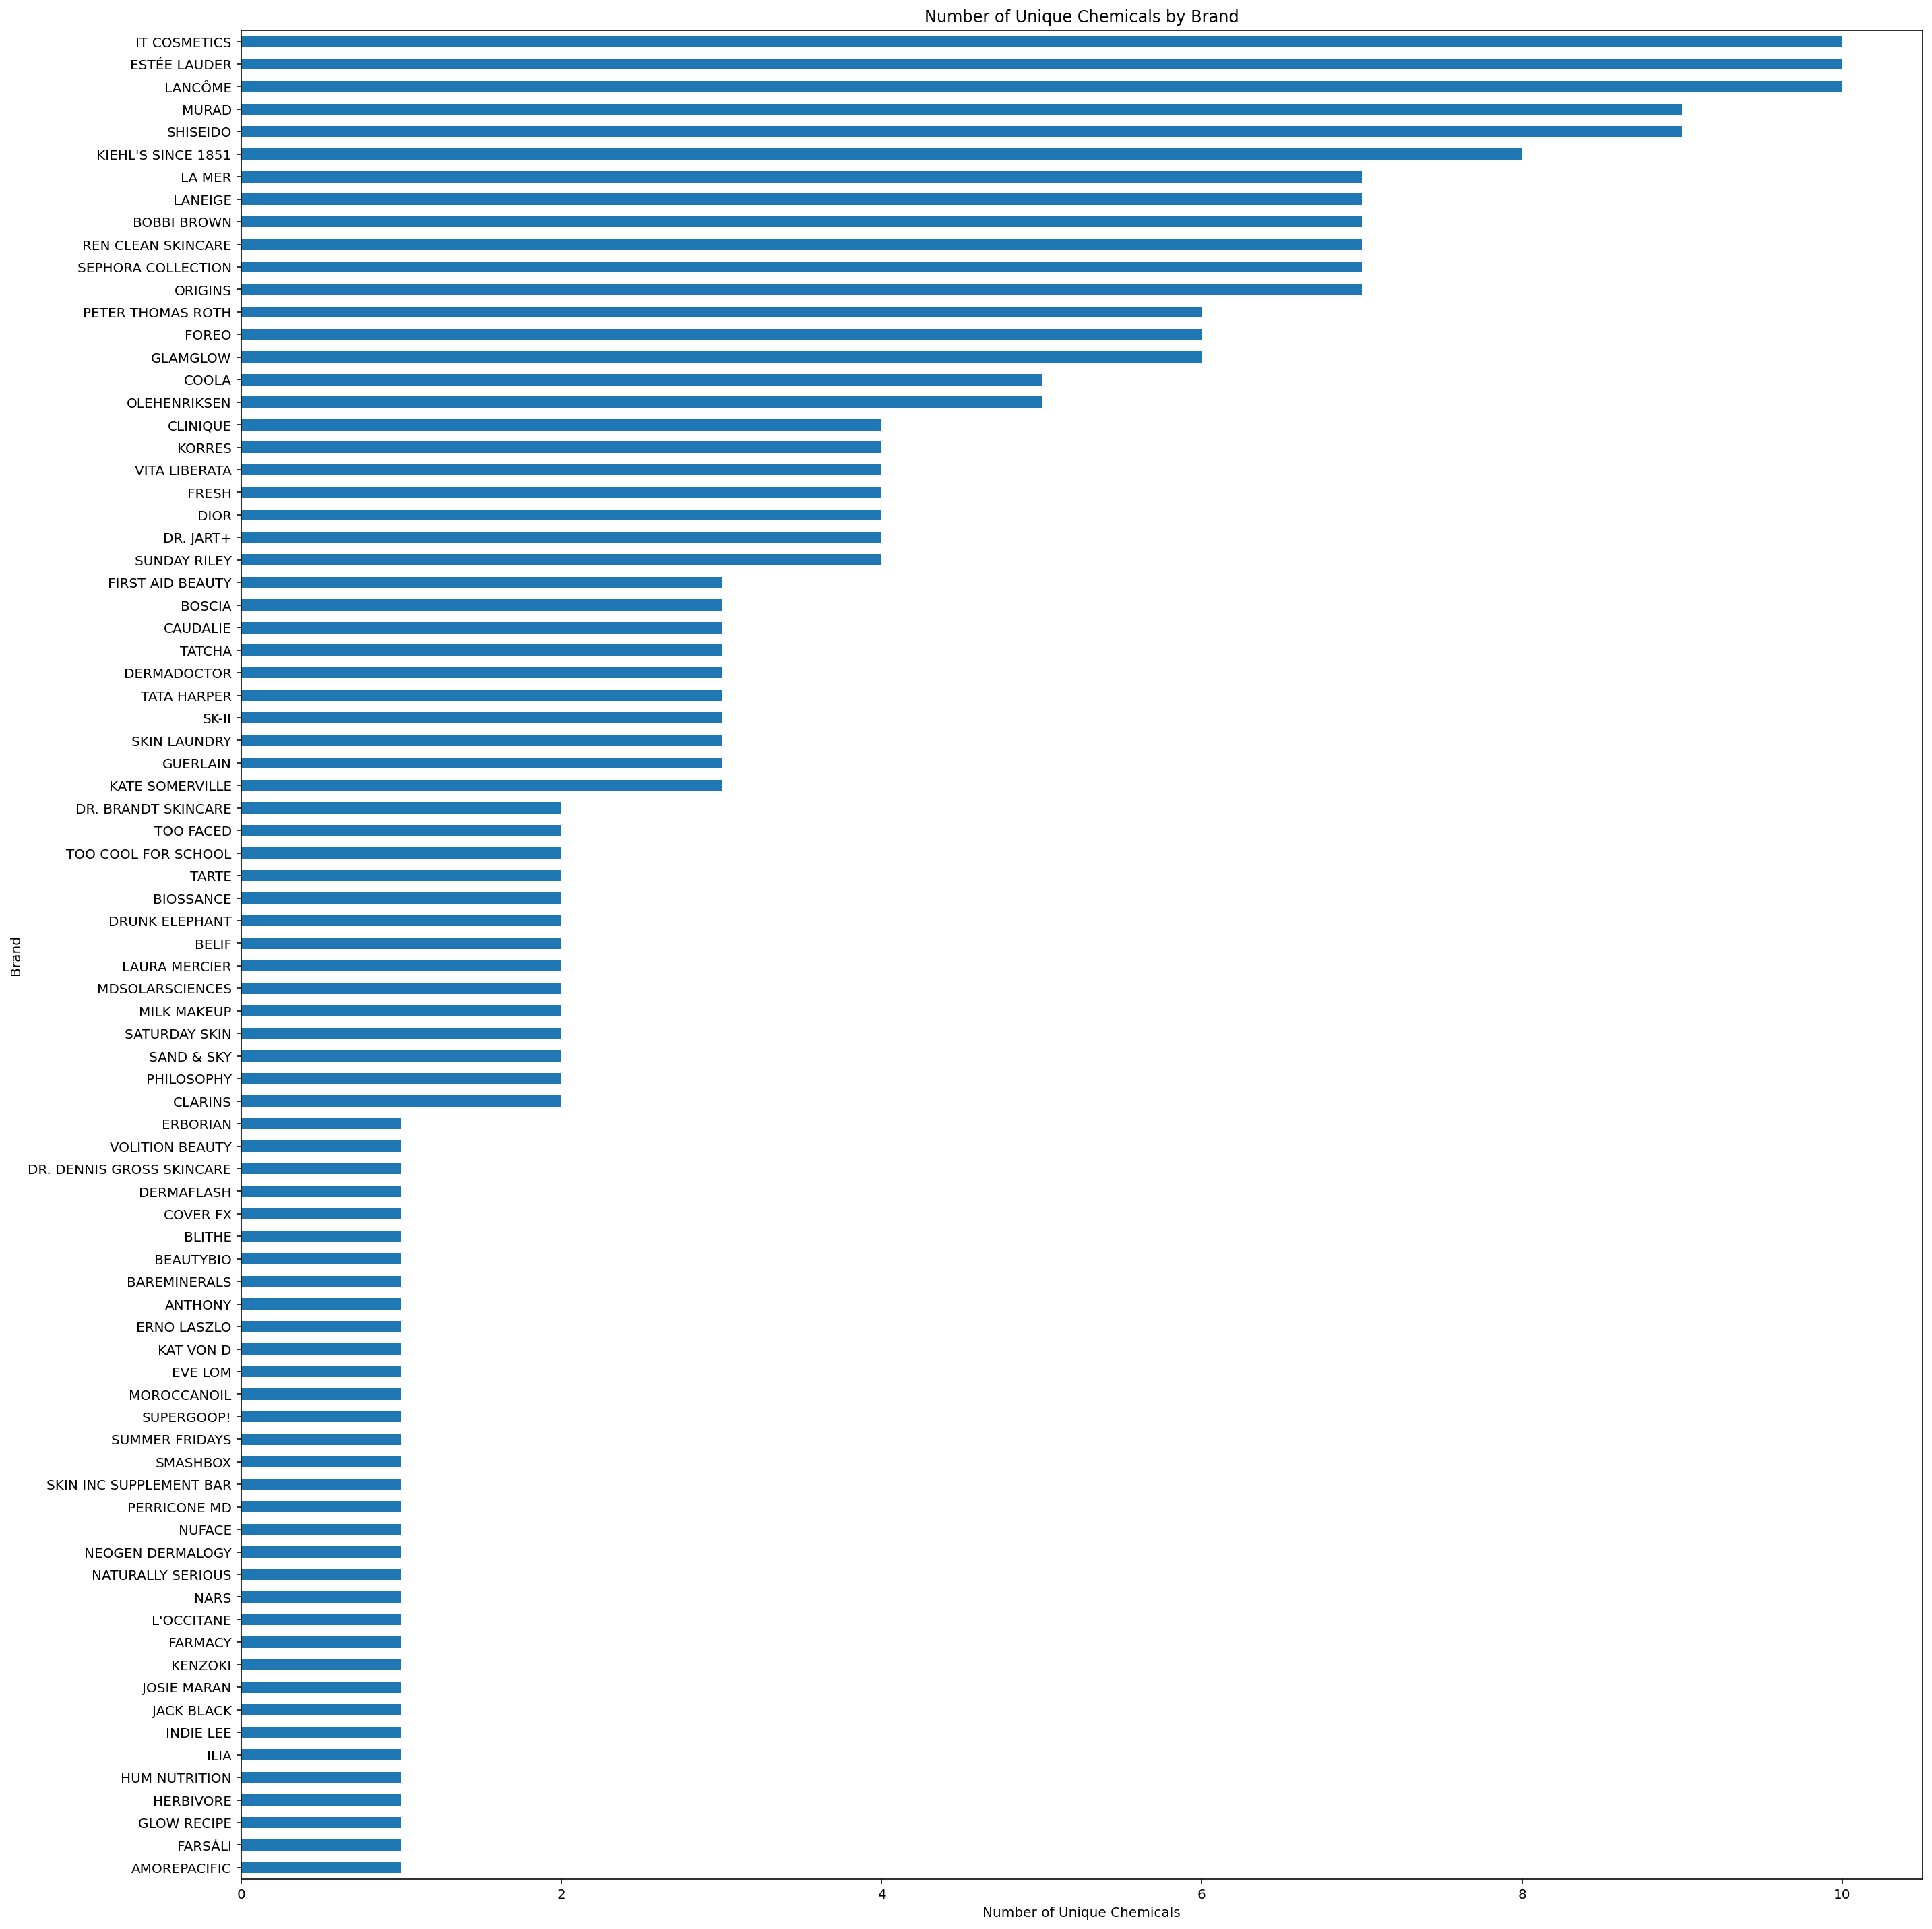

In [79]:
# number of unique chemicals per brand
chemicals_by_brand = balanced_df.groupby('brand')['ChemicalName'].nunique().sort_values()
plt.figure(figsize=(20, 20))
chemicals_by_brand.plot(kind='barh')
plt.xlabel('Number of Unique Chemicals')
plt.ylabel('Brand')
plt.title('Number of Unique Chemicals by Brand')
plt.tight_layout()
plt.show()

In [80]:
# pivot table to aggregate the binary values for each chemical and skin type combination
pivot_table = balanced_df.pivot_table(index='ChemicalName', 
                                values=['dry', 'normal', 'oily', 'sensitive'], 
                                aggfunc='sum')

<Figure size 1296x720 with 0 Axes>

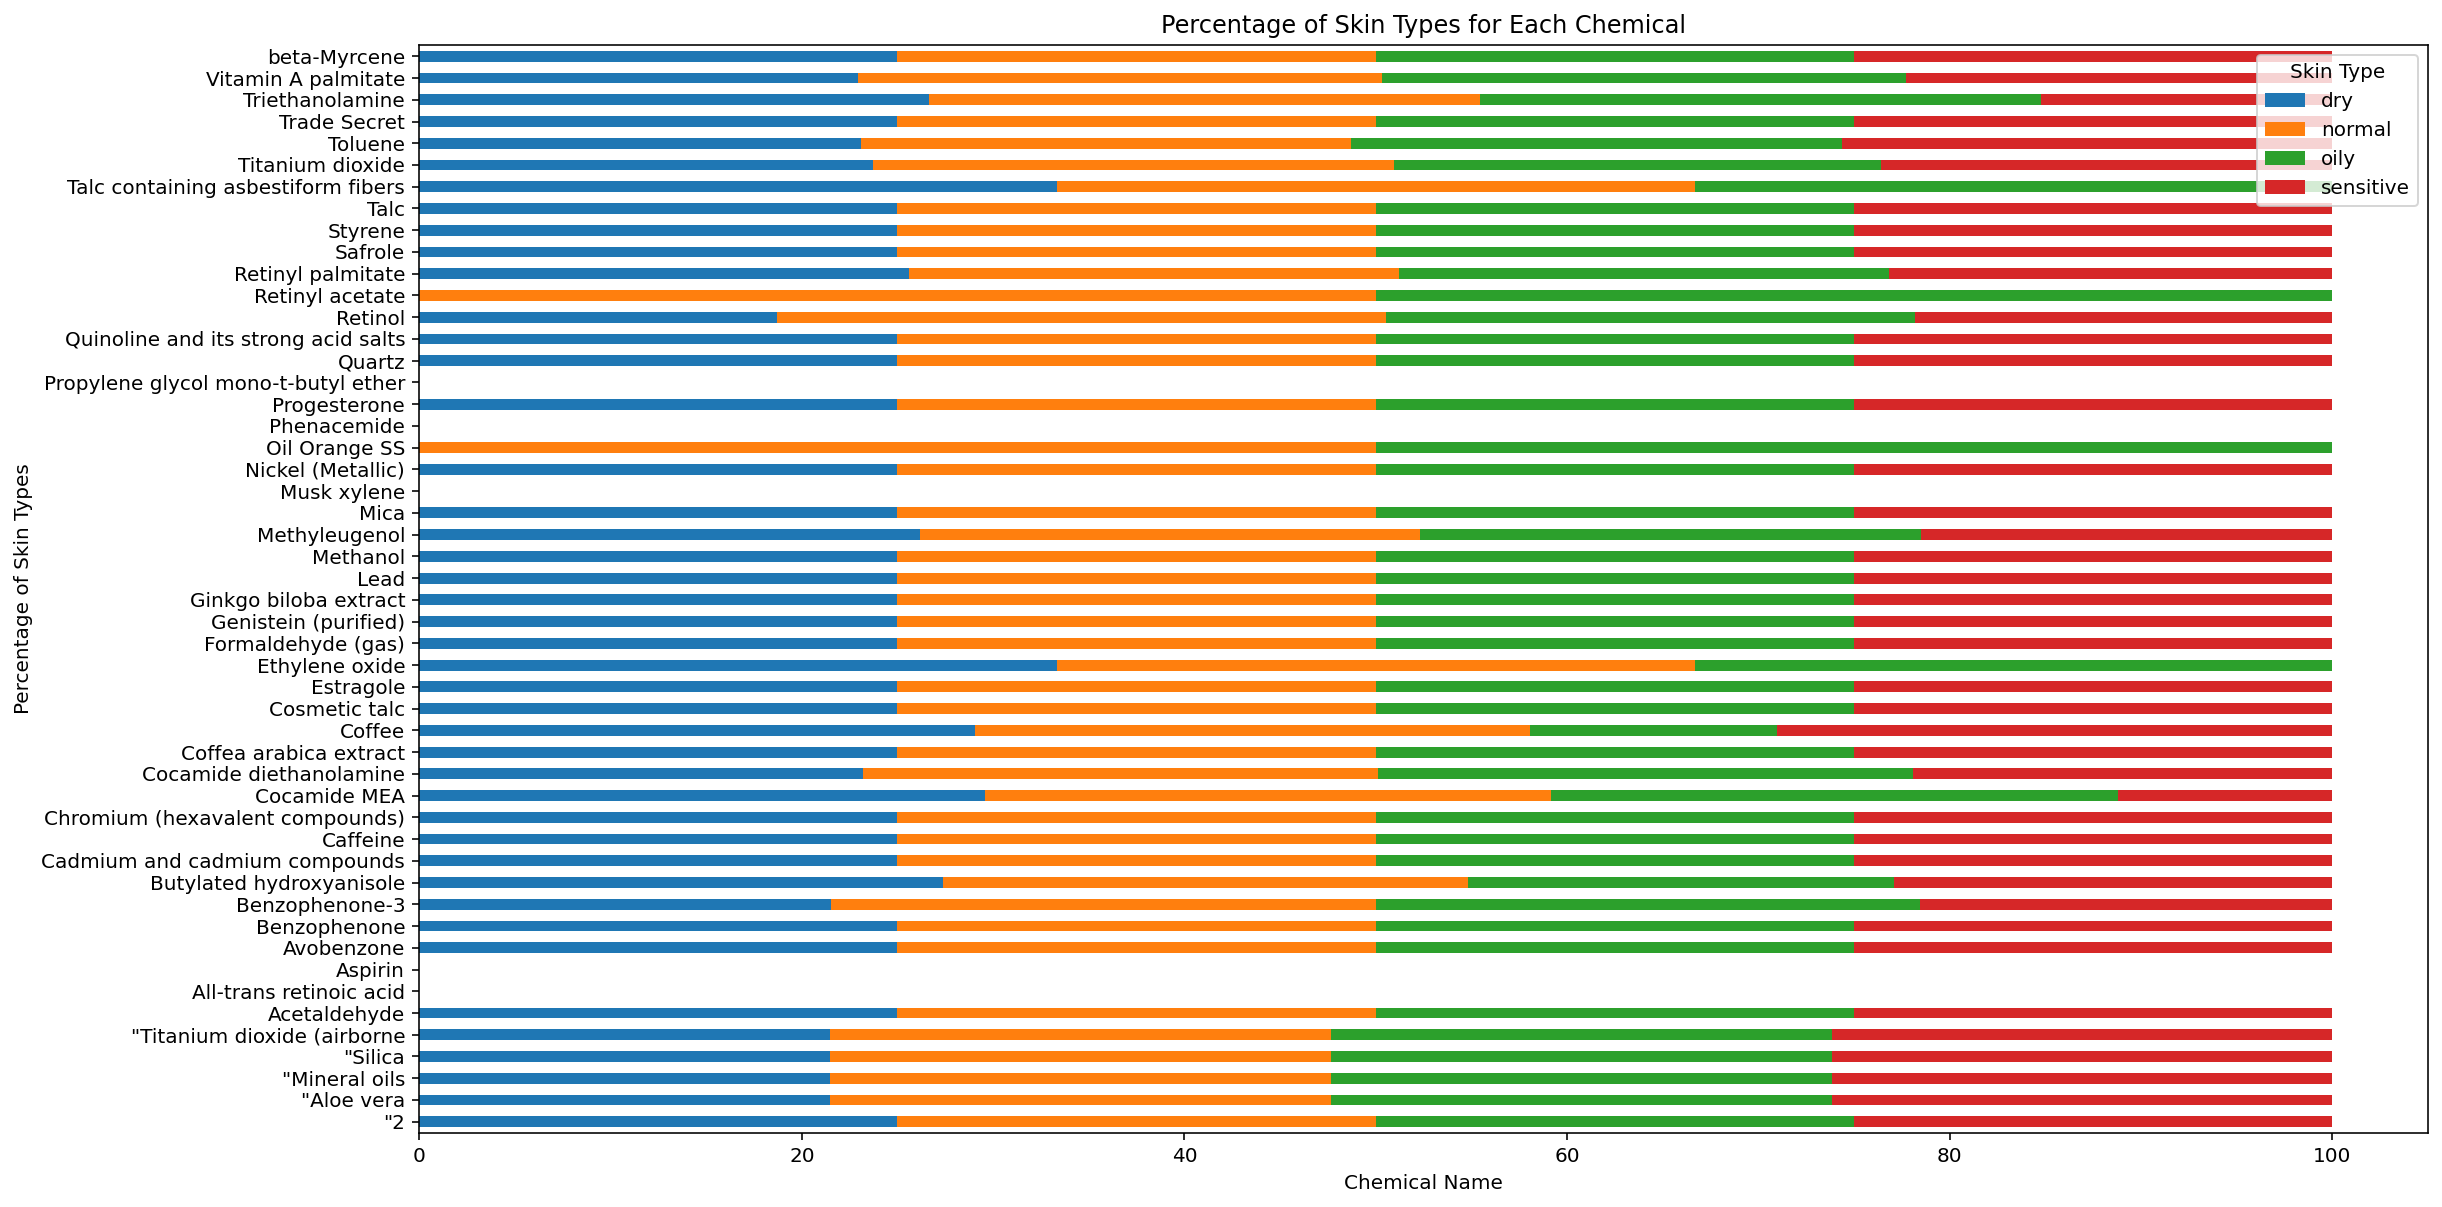

In [81]:
# calculate total number of chemicals per skin type
pivot_table['total'] = pivot_table.sum(axis=1)

# calculate percentage of each skin type for each chemical
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col] / pivot_table['total'] * 100
pivot_table.drop(columns='total', inplace=True)

# set figure size
plt.figure(figsize=(18, 10))

# plot % of skin types for each chemical 
pivot_table.plot(kind='barh', stacked=True, figsize=(18, 10))
plt.xlabel('Chemical Name')
plt.ylabel('Percentage of Skin Types')
plt.title('Percentage of Skin Types for Each Chemical')

plt.legend(title='Skin Type', loc='upper right')
plt.show();

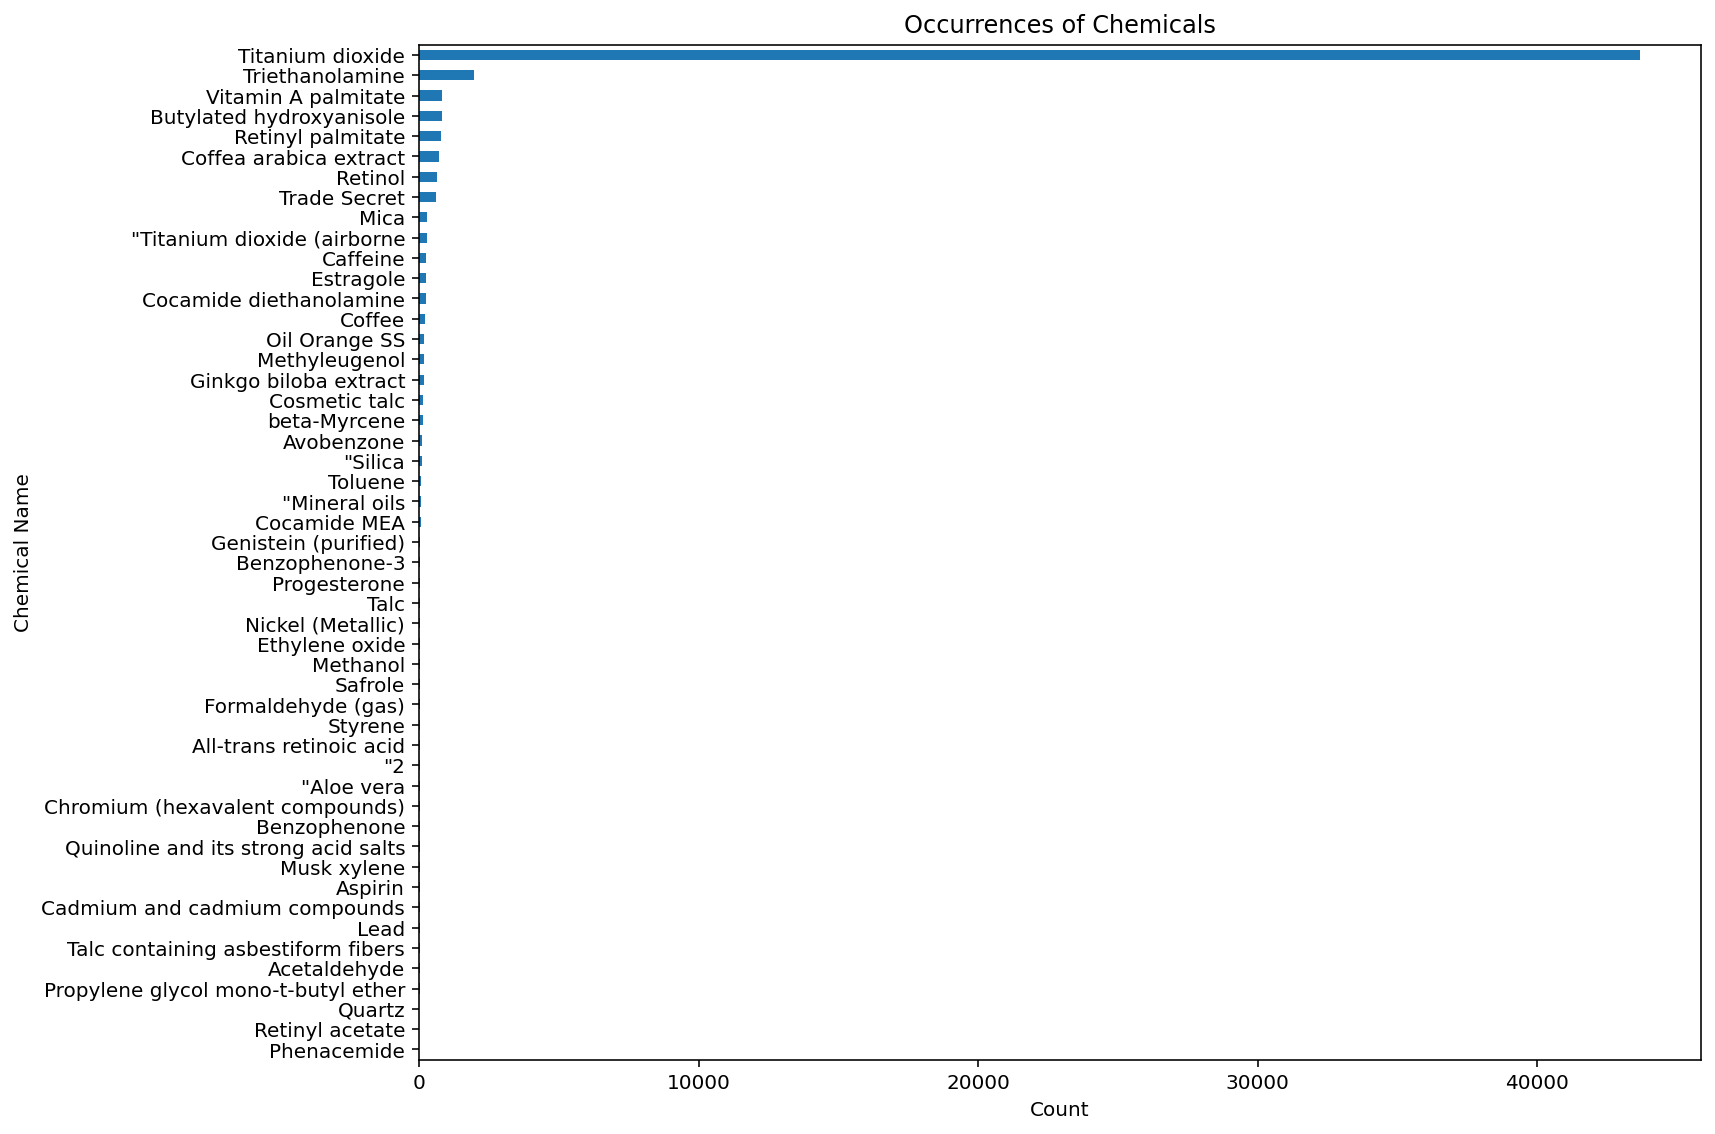

In [82]:
# count occurrences of each chemical
chemical_counts = balanced_df['ChemicalName'].value_counts()
chemical_counts_sorted = chemical_counts.sort_values(ascending=True)

# plot bar chart
plt.figure(figsize=(12, 8))
chemical_counts_sorted.plot(kind='barh')
plt.title('Occurrences of Chemicals')
plt.xlabel('Count')
plt.ylabel('Chemical Name')
plt.tight_layout()
plt.show()

In [83]:
# summary statistics of target column 'ordered'
balanced_df['ordered'].describe()

count    53325.000000
mean         0.134346
std          0.341027
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ordered, dtype: float64

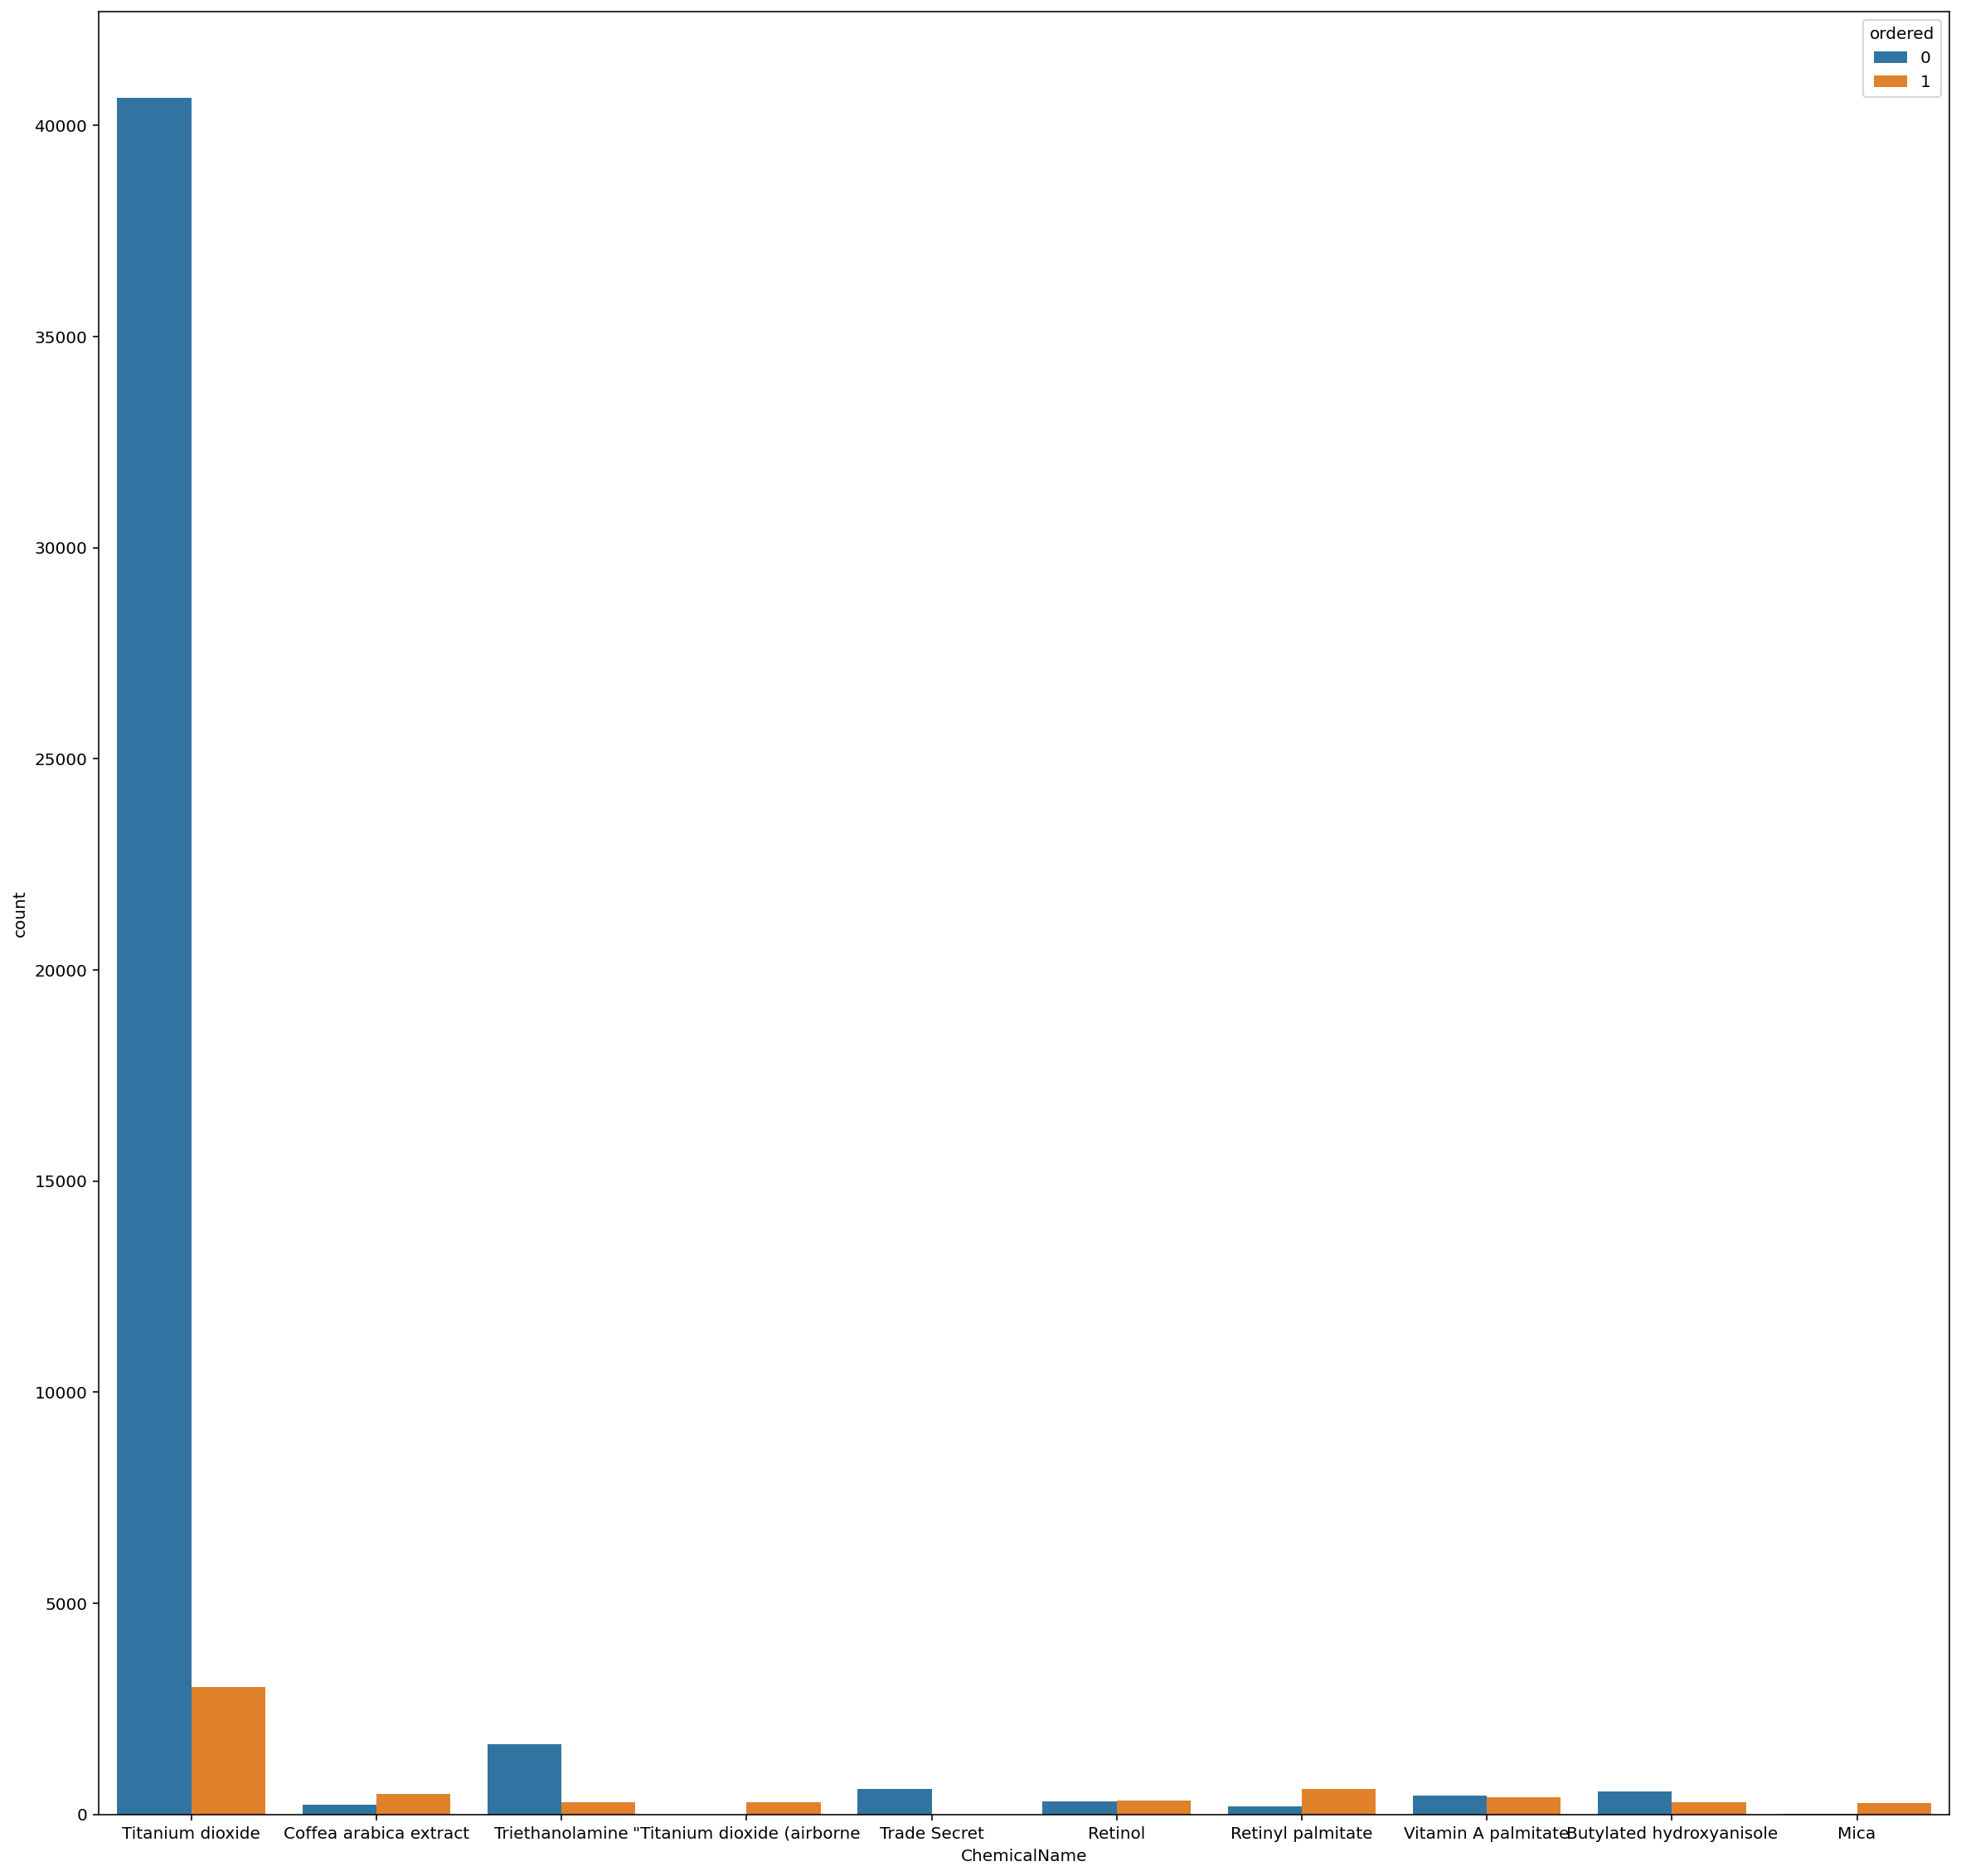

In [84]:
# create df for top chemicals + whether they were bought 
top_n_chemicals = balanced_df['ChemicalName'].value_counts().nlargest(10).index
top_n_df = balanced_df[balanced_df['ChemicalName'].isin(top_n_chemicals)]

# set figure
plt.figure(figsize=(20, 20))
sns.countplot(data=top_n_df, x="ChemicalName", hue="ordered")
plt.show()

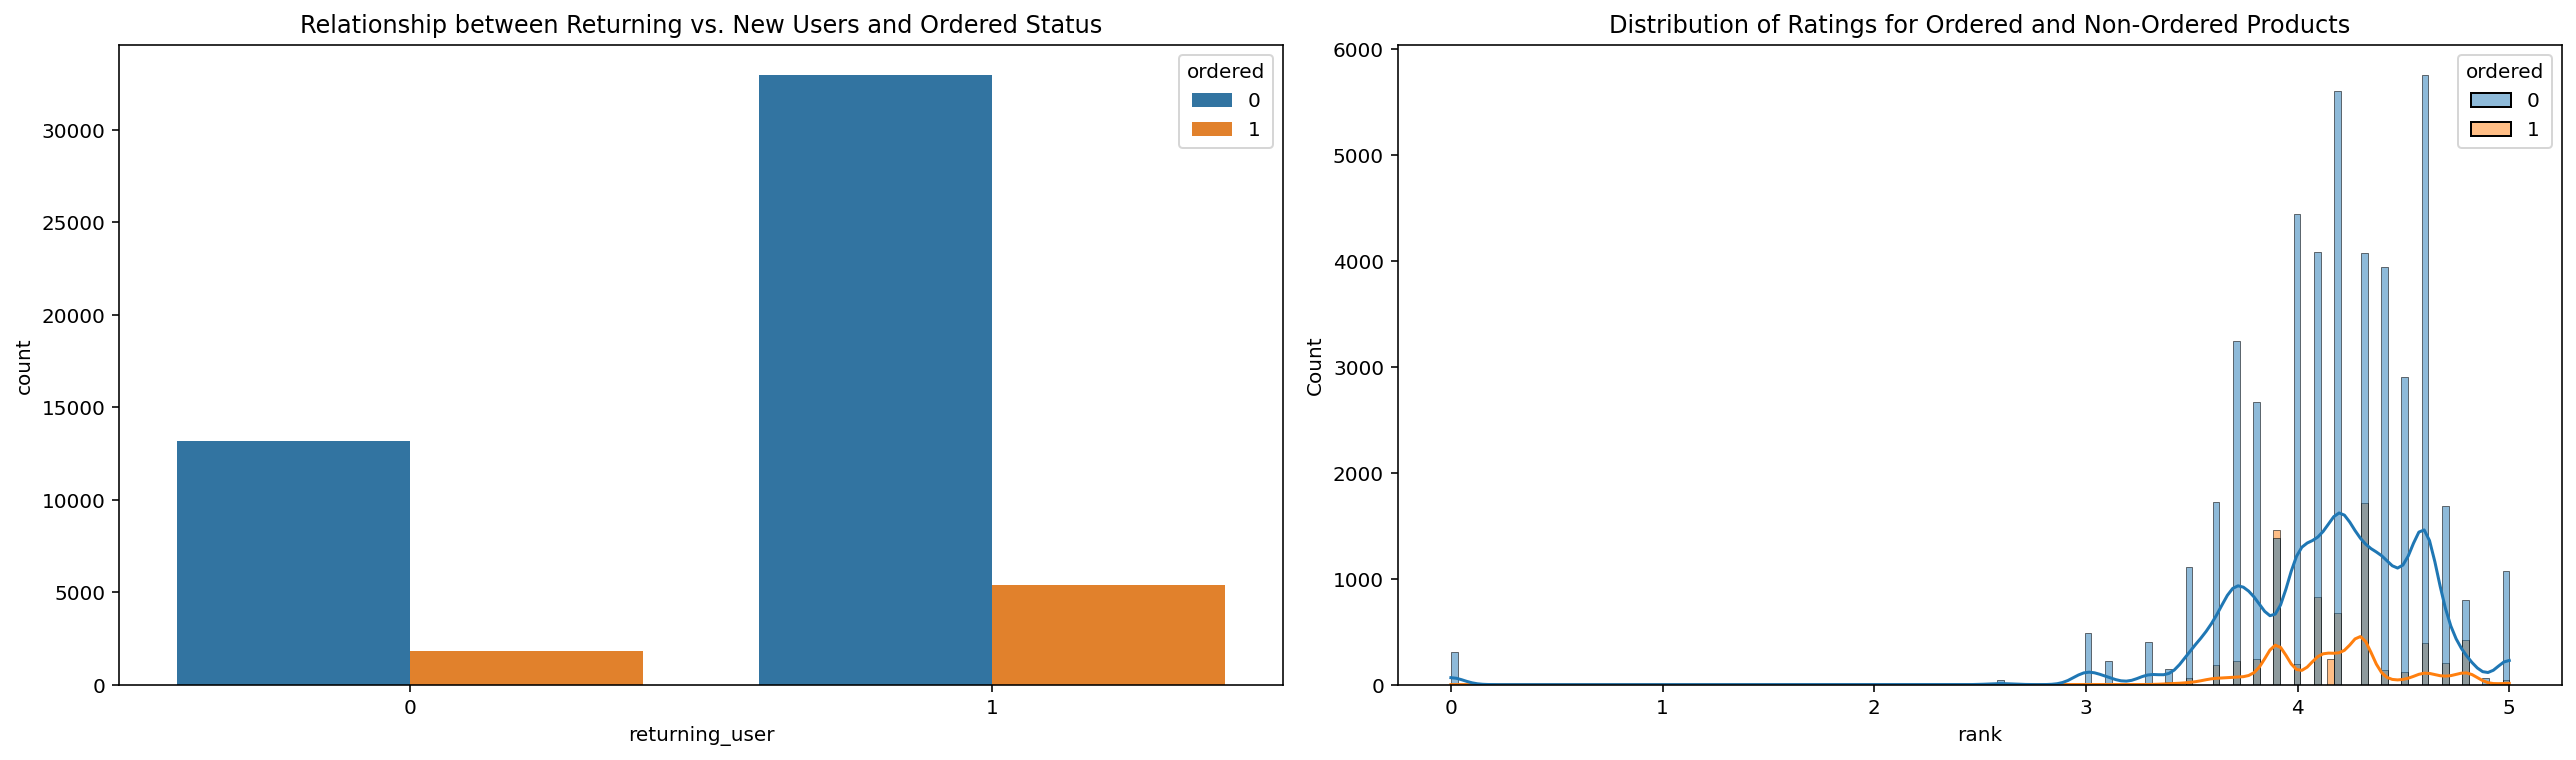

In [85]:
plt.figure(figsize=(18, 10))

# relationship between returning vs. new users and ordered status
plt.subplot(2, 2, 1)
sns.countplot(data=balanced_df, x='returning_user', hue='ordered')
plt.title('Relationship between Returning vs. New Users and Ordered Status')

# distribution of ratings for ordered and non-ordered products
plt.subplot(2, 2, 2)
sns.histplot(data=balanced_df, x='rank', hue='ordered', kde=True)
plt.title('Distribution of Ratings for Ordered and Non-Ordered Products')

plt.tight_layout()
plt.show()

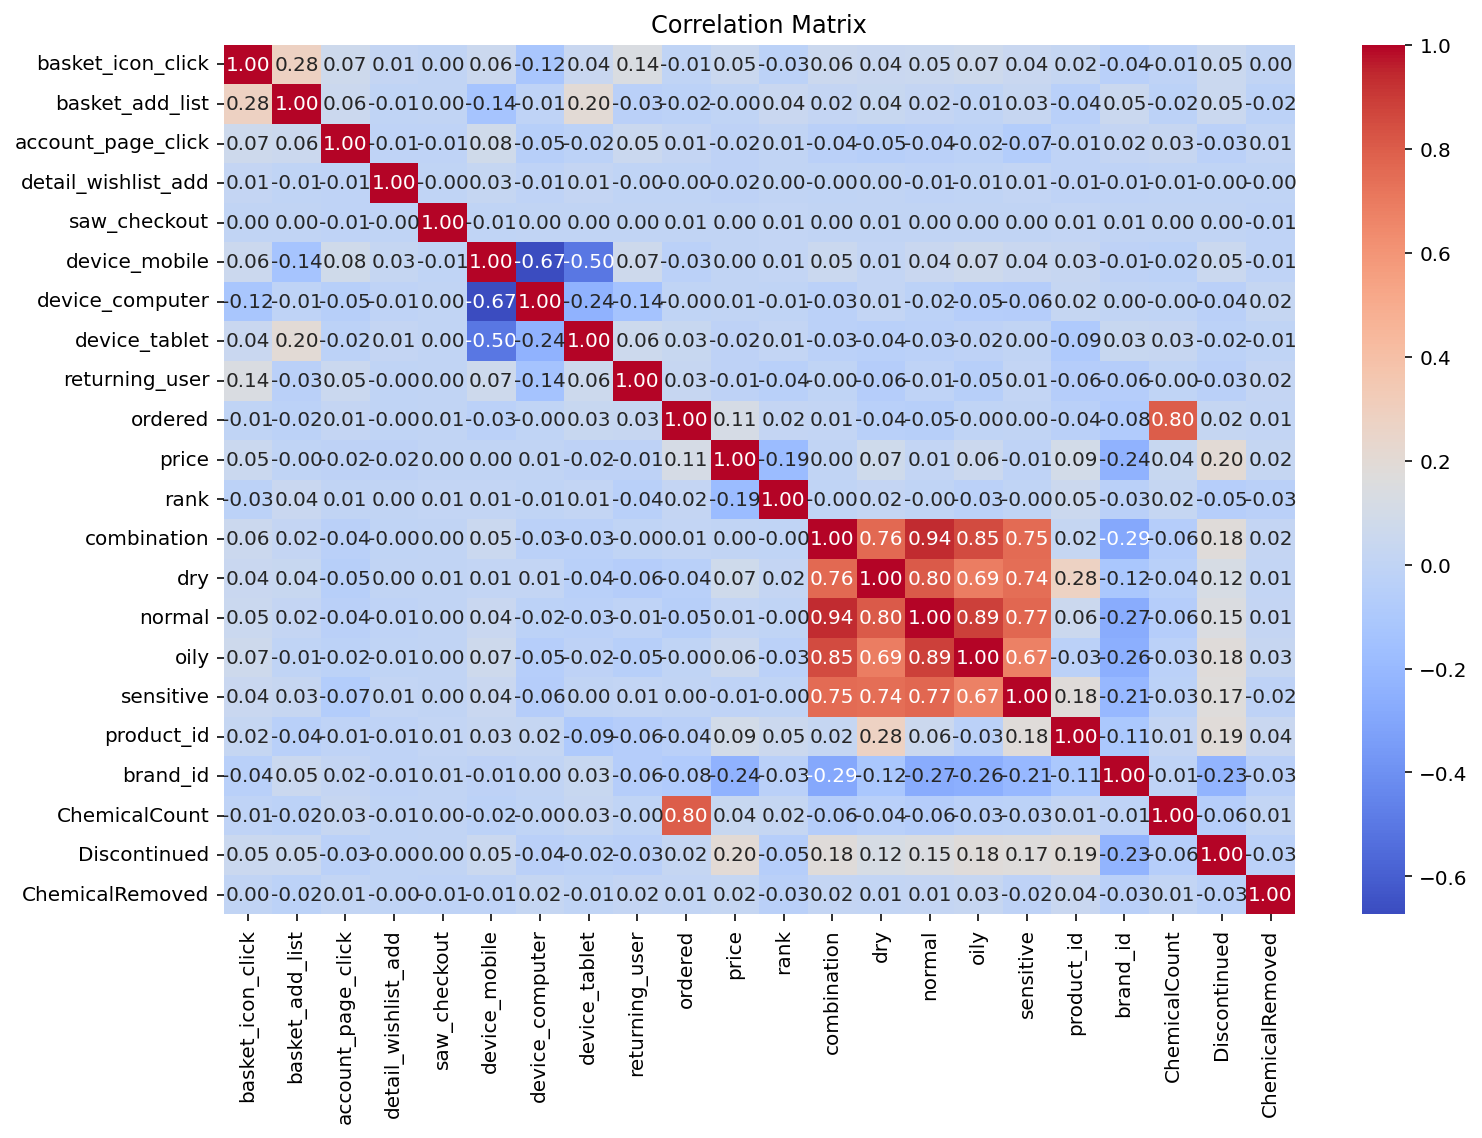

In [86]:
correlation_matrix = balanced_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Data Scrubbing 

#### Data Consistency

In [87]:
# Data consitency w/device columns 
inconsistent_records = balanced_df[(balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1]
print("Inconsistent records:", inconsistent_records)

Inconsistent records:                                     UserID  basket_icon_click  \
47359  d745-77b9d7c6-d745-4d64-84b8-565757                  0   
11354  3087-638av257-3087-4702-a224-859466                  1   
25213  9735-b70246ad-9735-433c-a7d7-605098                  1   
212    0546-ava6886d-0546-4774-a046-547739                  0   
47298  d745-77b9d7c6-d745-4d64-84b8-565757                  0   
...                                    ...                ...   
33159  b781-ada3aa8b-b781-4276-9816-441100                  0   
161    0546-ava6886d-0546-4774-a046-547739                  0   
43573  0725-99bdb41e-0725-4d69-b07b-166639                  1   
11394  3087-638av257-3087-4702-a224-859466                  1   
189    0546-ava6886d-0546-4774-a046-547739                  0   

       basket_add_list  account_page_click  detail_wishlist_add  saw_checkout  \
47359                0                   0                    0             0   
11354                1             

In [88]:
balanced_df.shape

(53325, 30)

In [89]:
# drop inconcistent records - rows where the sum of device columns is greater than 1
inconsistent_records_index = (balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1
balanced_df.drop(inconsistent_records_index.index[inconsistent_records_index], inplace=True)

In [90]:
balanced_df.shape

(52276, 30)

#### Data Type Conversion 

In [91]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52276 entries, 31078 to 15795
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               52276 non-null  object 
 1   basket_icon_click    52276 non-null  int64  
 2   basket_add_list      52276 non-null  int64  
 3   account_page_click   52276 non-null  int64  
 4   detail_wishlist_add  52276 non-null  int64  
 5   saw_checkout         52276 non-null  int64  
 6   device_mobile        52276 non-null  int64  
 7   device_computer      52276 non-null  int64  
 8   device_tablet        52276 non-null  int64  
 9   returning_user       52276 non-null  int64  
 10  ordered              52276 non-null  int64  
 11  label                52276 non-null  object 
 12  brand                52276 non-null  object 
 13  name                 52276 non-null  object 
 14  price                52276 non-null  float64
 15  rank                 52276 non-n

In [120]:
# Convert ChemicalCount, Discontinued, and ChemicalRemoved to integer type
balanced_df['ChemicalCount'] = balanced_df['ChemicalCount'].astype(int)
balanced_df['Discontinued'] = balanced_df['Discontinued'].astype(int)
balanced_df['ChemicalRemoved'] = balanced_df['ChemicalRemoved'].astype(int)
balanced_df['dry'] = balanced_df['dry'].astype(int)

#### Outlier Detection 

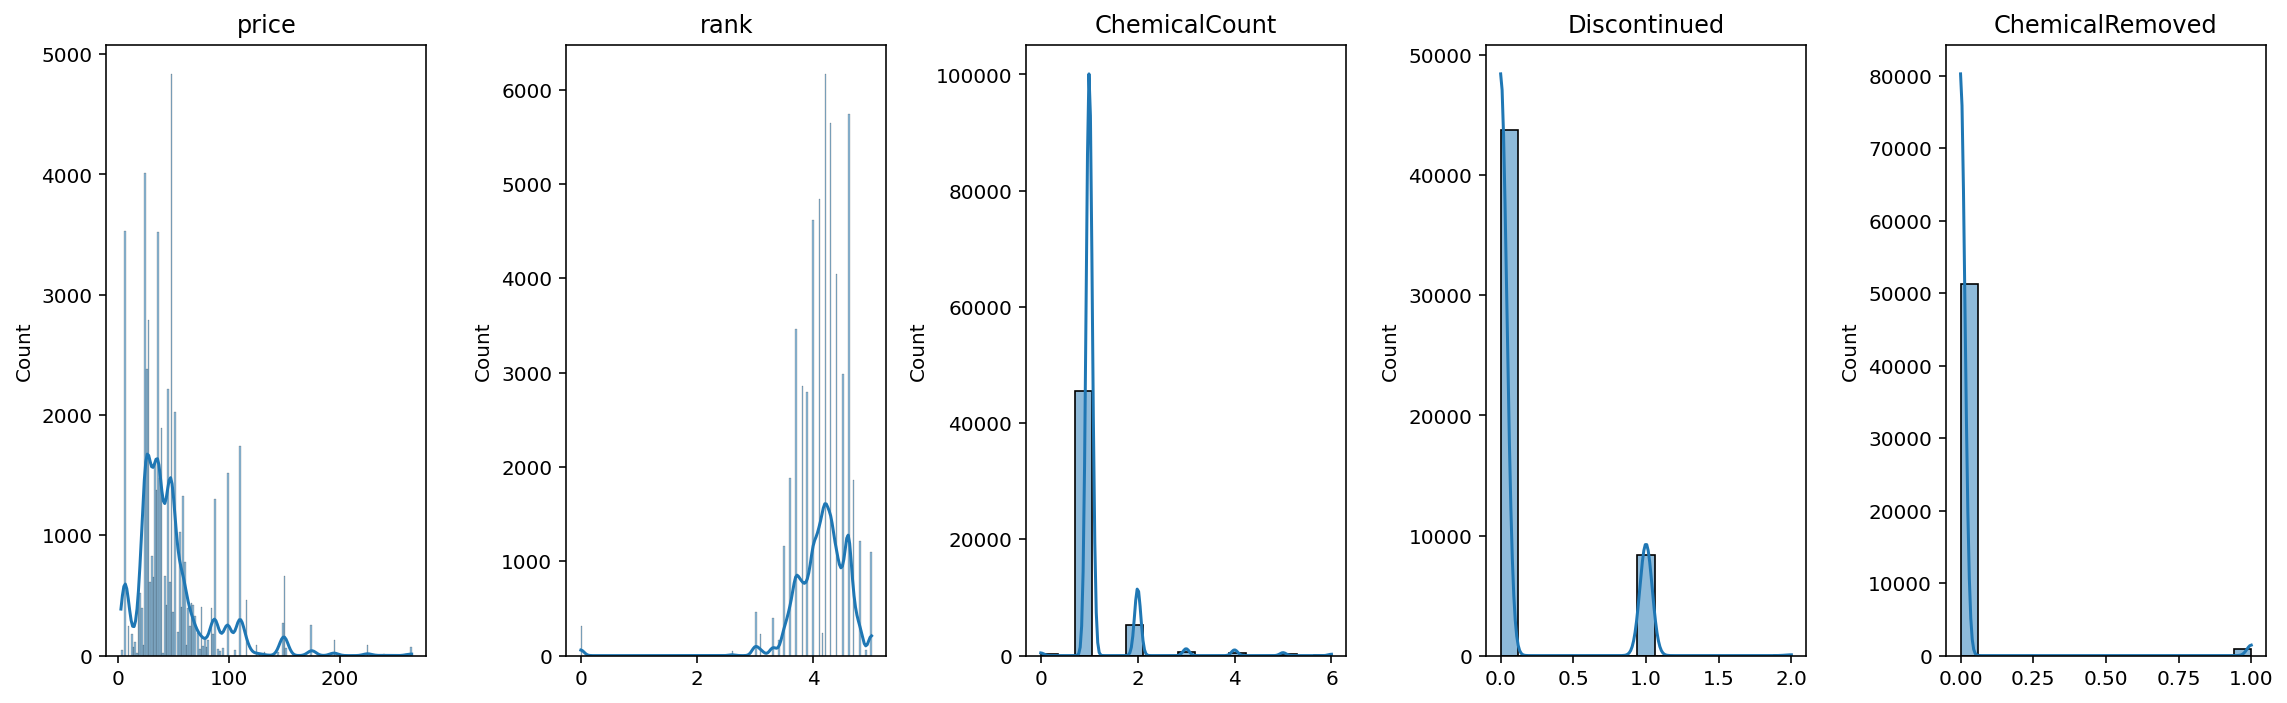

In [93]:
# visulaize potential outliers 
def visualize_distribution(balanced_df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 5))
    for i, col in enumerate(columns):
        sns.histplot(balanced_df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()

# define numerical columns for visualization
numerical_columns = ['price', 'rank', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved']
visualize_distribution(balanced_df, numerical_columns)

In [94]:
 balanced_df[numerical_columns].describe()

,price,rank,ChemicalCount,Discontinued,ChemicalRemoved
count,52276.000000,52276.000000,52276.000000,52276.000000,52276.000000
mean,48.705590,4.150159,1.170308,0.163287,0.017695
std,33.520187,0.497324,0.560364,0.372723,0.131840
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,3.900000,1.000000,0.000000,0.000000
50%,39.000000,4.200000,1.000000,0.000000,0.000000
75%,56.000000,4.400000,1.000000,0.000000,0.000000
max,265.000000,5.000000,6.000000,2.000000,1.000000


Keep all outliers, 

#### Duplicate Values 

In [95]:
# check for duplicates
balanced_df.duplicated().sum() #original df is 5227 rows 

32995

In [121]:
duplicate_rows = balanced_df[balanced_df.duplicated()]
duplicate_rows

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
16831,7ab6-56841e74-7ab6-4c60-a641-43512,0,0,0,0,0,1,0,0,1,0,Treatment,TATA HARPER,Resurfacing Serum,88.0,4.2,Hordeum Vulgare Leaf Juice*- Propanediol- Aqua...,1,1,1,1,1,105,674,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,1,0
32697,6833-32571a85-6833-4896-8297-691396,1,1,0,0,0,1,0,0,1,0,Sun protect,CLINIQUE,Superdefense SPF 20 Age Defense Moisturizer Co...,48.0,4.0,Avobenzone 3.00% - Octisalate 5.00%Water - But...,0,0,0,0,0,19,1371,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
1180,3536-1e594575-3536-4cc6-a07a-481288,1,1,0,0,0,0,0,1,1,0,Sun protect,CLINIQUE,Superdefense SPF 20 Age Defense Moisturizer Co...,48.0,4.0,Avobenzone 3.00% - Octisalate 5.00%Water - But...,0,0,0,0,0,19,1371,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1,0,0
41760,bb50-28459499-bb50-461c-8518-514019,0,1,0,0,0,1,0,0,1,0,Sun protect,FARMACY,Green Screen Daily Environmental Protector Bro...,36.0,4.6,Water- Ethyl Macadamiate- Cyclopentasiloxane- ...,1,1,1,1,1,35,1325,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
21052,5642-c776771a-5642-4976-ab38-433170,1,1,0,0,0,0,0,1,1,0,Cleanser,CAUDALIE,Vinopure Natural Salicylic Acid Pore Minimizin...,28.0,3.8,*Plant origin.,1,0,1,1,1,15,352,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1c4a-760c7602-1c4a-4b2c-b635-228019,1,1,0,0,1,1,0,0,0,0,Treatment,DR. DENNIS GROSS SKINCARE,Alpha Beta® Medi–Spa Peel,64.0,4.5,Visit the Dr. Dennis Gross Skincare boutique,1,1,1,1,0,27,668,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
44732,d8d7-15018d54-d8d7-4c04-ac64-209055,1,1,0,0,1,1,0,0,1,0,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4.3,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1,1,0,1,108,886,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
38158,7d00-9714cd3a-7d00-4892-8b78-495078,0,0,0,0,1,1,0,0,1,1,Sun protect,DIOR,One Essential City Defense SPF 50,59.0,4.3,Visit the Dior boutique,0,0,0,0,0,24,1370,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,2,0,0
860,avb4-65cccd6a-avb4-4719-96b6-978804,0,1,0,0,1,0,1,0,1,1,Sun protect,DIOR,One Essential City Defense SPF 50,59.0,4.3,Visit the Dior boutique,0,0,0,0,0,24,1370,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Coffea arabica extract,2,0,0


In [114]:
duplicate_rows['UserID'].value_counts()

b546-1695b9d0-b546-4629-a7bd-747284    251
5642-c776771a-5642-4976-ab38-433170    250
7270-19b97296-7270-474c-8c91-805757    250
0763-8096827d-0763-4d72-98a7-302523    249
7b7d-5b0890b5-7b7d-4618-b634-987843    248
                                      ... 
7374-d678b097-7374-4503-9622-594421      1
3930-d25d1570-3930-4771-ada5-746939      1
9074-714d22a2-9074-418b-98ad-252936      1
a332-45064cc8-a332-4b72-87d2-454416      1
2bb9-dac62a11-2bb9-4d42-95bd-452926      1
Name: UserID, Length: 771, dtype: int64

In [117]:
# remove driuplicate rows here 